In [ ]:
import sys
import os
import site

print(f"Original Python: {sys.executable}")

# 1. Install strict versions to USER directory (no sudo needed)
!{sys.executable} -m pip install --user --force-reinstall "numpy==1.26.4" "transformers==4.38.2" "peft==0.10.0" "datasets==2.18.0" "accelerate==0.28.0"

# 2. Find and Insert User Site-Packages to TOP of path to shadow global libs
# (This ensures we load the NEW numpy/transformers, not the broken system ones)
user_site = site.getusersitepackages()
if isinstance(user_site, str):
    user_site = [user_site]

for path in user_site:
    if path not in sys.path:
        sys.path.insert(0, path)
    else:
        # Move to front
        sys.path.remove(path)
        sys.path.insert(0, path)

print(f"✅ Override Enabled. Preferred Paths: {user_site}")

Original Python: /usr/local/opt/python@3.9/bin/python3.9
  Using cached numpy-1.26.4-cp39-cp39-macosx_10_9_x86_64.whl (20.6 MB)
  Using cached transformers-4.38.2-py3-none-any.whl (8.5 MB)
  Using cached peft-0.10.0-py3-none-any.whl (199 kB)
  Using cached datasets-2.18.0-py3-none-any.whl (510 kB)
     |████████████████████████████████| 290 kB 3.2 MB/s eta 0:00:01
  Using cached requests-2.32.5-py3-none-any.whl (64 kB)
  Using cached pyyaml-6.0.3-cp39-cp39-macosx_10_13_x86_64.whl (184 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl (566 kB)
  Using cached packaging-26.0-py3-none-any.whl (74 kB)
  Using cached tokenizers-0.15.2-cp39-cp39-macosx_10_12_x86_64.whl (2.6 MB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached filelock-3.19.1-py3-none-any.whl (15 kB)
  Using cached regex-2026.1.15-cp39-cp39-macosx_10_9_x86_64.whl (290 kB)
  Using cached safetensors-0.7.0-cp38-abi3-macosx_10_12_x86_64.whl (467 kB)
  Using cached psutil-7.2.2-cp36-abi3-macosx_10_9_x86_

In [2]:
# Verify Logic - Requires Kernel Restart IF numpy was already loaded in memory
import numpy as np
import transformers
import accelerate

print(f"Numpy: {np.__version__} (Target: 1.26.4)")
print(f"Transformers: {transformers.__version__} (Target: 4.38.2)")
print(f"Accelerate: {accelerate.__version__} (Target: 0.28.0)")

if np.__version__ != "1.26.4" or transformers.__version__ != "4.38.2" or accelerate.__version__ != "0.28.0":
    print("\n⚠️ VERSIONS NOT UPDATED YET? ")
    print("You MUST restart the kernel (Toolbar -> Restart) for the new sys.path to take effect cleanly.")
    # Stop execution to force restart
    raise SystemExit("Please Restart Kernel to load the installed fix.")
else:
    print("✅ Environment is PERFECT. Proceeding...")

/Users/manueladalborgo/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Numpy: 1.26.4 (Target: 1.26.4)
Transformers: 4.38.2 (Target: 4.38.2)
Accelerate: 0.28.0 (Target: 0.28.0)
✅ Environment is PERFECT. Proceeding...


## Beginner's Corner: Tensors & Training Visualization

### 1. Visualizing the Flow
Here is what happens inside the code when we say `model(input)`. 
The data transforms from **Text** -> **Numbers (Tensor)** -> **Math (Weights)** -> **Output**.

![Tensor Training Diagram](/Users/manueladalborgo/.gemini/antigravity/brain/e5bad3ba-7241-45fa-b434-ac592285b756/tensor_training_diagram_1769689992098.png)

### 2. Concrete Example: "See the Math"
How does the model actually *learn*? It's just adjusting numbers to reduce error.

**Step A: Forward Pass (Guessing)**
- **Input**: `[0.5, 0.5]` (representing word "Hello")
- **Weights**: `[2.0, 1.0]` (Randomly initialized)
- **Math**: `0.5*2.0 + 0.5*1.0` = `1.5`
- **Output**: `1.5`

**Step B: Calculate Loss (How wrong were we?)**
- **Target**: Should have been `4.0` (representing word "World")
- **Loss**: `4.0 - 1.5` = `2.5` (We were too low!)

**Step C: Backward Pass (Learning)**
- The "Gradient" tells us: *"If you increase the weights, the output will go up."*
- **Update**: Change Weights from `[2.0, 1.0]` -> `[2.1, 1.1]`
- **Next Time**: `0.5*2.1 + 0.5*1.1` = `1.6` (Closer to 4.0!)

> **Training** is just doing this loop millions of times until the logical output is perfect.

# 01. LLM Fine-Tuning with LoRA (Parameter-Efficient Fine-Tuning)

**Objective**: Fine-tune a Causal Language Model (GPT-2) using Low-Rank Adaptation (LoRA).

## Why this matters for an Interview with a cybersecurity firm:
A cybersecurity firm deals with high-throughput, low-latency systems. They don't just want you to know *how* to call `trainer.train()`; they want to know *what happens to the weights* and *how this affects inference latency*.

**Term Check:**
- **High-Throughput**: Processing a massive volume of data (e.g., millions of network logs) per second.
- **Low-Latency**: Providing an answer (e.g., blocking a threat) almost instantly after the data arrives.

### 🔎 What a cybersecurity firm will likely ask next:
> **"Why Causal LM instead of Masked LM here?"**

**Answer**: We are training a generative model (like GPT), which predicts the *next token* based on previous tokens (autoregressive). This requires a **Causal Mask** (a triangular mask that prevents the model from peeking at future tokens). 

**The Math Difference**:
- **Causal LM (GPT)** factorizes probability as $P(x) = \prod P(x_i | x_{<i})$ (conditioning only on past).
- **Masked LM (BERT)** models $P(x_i | x_{\setminus i})$ (conditioning on past and future contexts).

---

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, TaskType
from datasets import Dataset
import os

# Ensure deterministic behavior for reproducibility
torch.manual_seed(42)

/usr/local/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## 1. Configuration & Hyperparameters

We are increasing the **Batch Size** and **Epochs** from the original script.

- **Batch Size (16)**: Larger batch sizes provide a more stable estimate of the gradient (less noise), leading to smoother convergence. However, it requires more VRAM.
- **Epochs (3)**: One epoch is often insufficient for the model to learn specific patterns in a small dataset (underfitting).
- **Padding**: Crucial for batching! We cannot stack tensors of different lengths into a single matrix. We must pad them to the same length.

### 🖼️ Visualizing VRAM Usage & Activations 

**Question**: Why does "storing activations" eat memory when we increase Batch Size?

**1. The Calculus Reason (Chain Rule)**
To calculate how to adjust a weight ($w$), we need the error form the layer above ($\delta$) AND the input that entered the weight ($x$).
$$ \frac{\partial Loss}{\partial w} = \delta \times x $$
If we discard $x$ to save memory after the forward pass, we can't compute the update for $w$ during the backward pass!

**2. The Memory Stack (Visualized)**
```text
[ GPU VRAM ]
+---------------------------+
| Model Weights (Fixed)     | 
| (e.g., 5GB for LLM)       |
+---------------------------+
| Optimizer States (Fixed)  | 
| (e.g. Momentum for Adam)  |
+---------------------------+
| Forward Pass Activations  | <--- THIS GROWS LINEARLY WITH BATCH SIZE!
| +-----------------------+ |      If Batch=1, we store 1 layer of inputs.
| | Sample 1 Values (x)   | |      If Batch=16, we store 16x the data.
| +-----------------------+ |      This is usually the bottleneck causing OOM.
| | Sample 2 Values (x)   | |
| +-----------------------+ |
| | ...                   | |
| +-----------------------+ |
| | Sample 16 Values (x)  | |
| +-----------------------+ |
+---------------------------+
```


In [4]:
MODEL_NAME = "gpt2"  # Small model for demo. In production, you'd use Llama-3-8b or Mistral.

# LoRA Hyperparameters
LORA_R = 16          # Rank: Higher = more expressivity, but more parameters.
LORA_ALPHA = 32      # Scaling factor: Usually set to 2x Rank.
LORA_DROPOUT = 0.05  # Regularization to prevent overfitting.

# Training Hyperparameters
LEARNING_RATE = 2e-4 # Standard LoRA LR (higher than full fine-tuning which is usually 1e-5)
BATCH_SIZE = 16      # Increased from 4 for gradient stability
EPOCHS = 3           # Increased from 1 to ensure convergence
OUTPUT_DIR = "./lora_finetuned_model"

## 2. Model Loading & Tokenizer

### 🔎 What a cybersecurity firm will likely ask next:
> **"What breaks if sequence length increases?"**

**Answer**:
1.  **Quadratic Memory Cost**: The Self-Attention mechanism computes an $N \times N$ matrix (where $N$ is sequence length). If you double the sequence length ($2N$), the memory usage quadruples ($4N^2$). This causes OOM (Out of Memory) errors rapidly.
2.  **Positional Embeddings**: Models like GPT-2 use absolute positional embeddings trained up to a fixed length (e.g., 1024). Use beyond this length fails unless you use Rotary Embeddings (RoPE) or ALiBi which extrapolate better.

In [5]:
print(f"Loading base model: {MODEL_NAME}...")
try:
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
except OSError:
    print("Model data not found locally. Mocking mechanism for offline demo.")
    model = torch.nn.Linear(10, 10) # Placeholder
    exit() # Stop if no model

# Fix for GPT-2 which has no pad token by default
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Set pad_token to eos_token.")

Loading base model: gpt2...


/Users/manueladalborgo/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Set pad_token to eos_token.


## 3. Applying LoRA (Low-Rank Adaptation)

### 🔎 What a cybersecurity firm will likely ask next:
> **"Which weights does LoRA modify and why?"**

**Answer**:
- LoRA typically targets the **Attention Weights** ($W_{query}, W_{value}$). 
- **Why?**
  - **MLP (Multi-Layer Perceptron)**: Think of this as the "Reasoning" or "Factual" part of the brain. It processes information to make a decision.
  - **Attention**: Think of this as the "Research" or "Routing" part of the brain. It looks at different words to find connections.
  - **Intrinsic Rank**: This is a fancy term for **"How hard is it to change the model's mind?"** attention layers have a "high intrinsic rank" for adaptation, meaning we can change the model's behavior significantly just by tweaking the Attention, without having to re-train the entire brain (MLP).
- By freezing the main weights ($W$) and learning delta matrices ($A \times B$), we reduce trainable limits by ~1000x.

In [6]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, 
    inference_mode=False, 
    r=LORA_R, 
    lora_alpha=LORA_ALPHA, 
    lora_dropout=LORA_DROPOUT,
    # target_modules=["c_attn"] # For GPT-2, 'c_attn' is the projection layer
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 589,824 || all params: 125,029,632 || trainable%: 0.4717473694555863


/Users/manueladalborgo/Library/Python/3.9/lib/python/site-packages/peft/tuners/lora/layer.py:1059: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


## 4. Data Preparation & Cleaning (Real LANL Data)

We load the **real** LANL dataset (`auth.txt.gz`) which contains authentication logs. 
To use this for Language Modeling, we convert the structured CSV rows into natural language sequences.

In [7]:
# Load Real LANL Data (Subset for Demo)
import pandas as pd

LANL_PATH = "LANL_Auth_Triage_Project/auth.txt.gz"

# Check if file exists, else warn
if not os.path.exists(LANL_PATH):
    print(f"⚠️ File {LANL_PATH} not found. Using synthetic fallback.")
    data = [
        {"text": "Time: 1 User: U1@Dom1 Src: C1 Dst: C2 Type: NTLM Res: Success"}, 
        {"text": "Time: 2 User: U1@Dom1 Src: C1 Dst: C2 Type: Kerberos Res: Fail"}
    ] * 50
else:
    print(f"Loading real LANL data from {LANL_PATH}...")
    # Read first 10,000 rows to keep things fast
    df = pd.read_csv(
        LANL_PATH, 
        compression='gzip', 
        names=["time", "src_user", "dst_user", "src_comp", "dst_comp", "auth_type", "logon_type", "auth_orient", "success"],
        header=None,
        nrows=10000
    )
    
    # Convert row to text format for LLM
    # Format: "Time: <t> User: <u> Src: <sc> Dst: <dc> Type: <at> Res: <s>"
    def row_to_text(row):
        return f"Time: {row['time']} User: {row['src_user']} Src: {row['src_comp']} Dst: {row['dst_comp']} Type: {row['auth_type']} Res: {row['success']}"
    
    df['text'] = df.apply(row_to_text, axis=1)
    data = df[['text']].to_dict('records')
    print(f"Loaded {len(data)} rows from LANL dataset.")
    print("Sample:", data[0])

dataset = Dataset.from_list(data)

def tokenize_function(examples):
    # padding='max_length' ensures all vectors in a batch are same size (e.g., 64)
    # truncation=True ensures we don't crash on OOM if a sample is massive
    return tokenizer(
        examples["text"], 
        padding="max_length", 
        truncation=True, 
        max_length=64
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Loading real LANL data from LANL_Auth_Triage_Project/auth.txt.gz...
Loaded 10000 rows from LANL dataset.
Sample: {'text': 'Time: 1 User: ANONYMOUS LOGON@C586 Src: C1250 Dst: C586 Type: NTLM Res: Success'}


Map: 100%|██████████| 10000/10000 [00:00<00:00, 22776.77 examples/s]


## 5. Training

We use the `Trainer` API. Note that `DataCollatorForLanguageModeling` handles the labels. It shifts the inputs by 1 automatically so the model learns to predict the next token.

In [8]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    logging_steps=5,
    logging_strategy="steps",
    save_strategy="no",
    report_to="none",  # avoids wandb/tensorboard side effects
    use_cpu=not torch.cuda.is_available(),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

print("Starting LoRA Training...")
trainer.train()
print("Training complete.")

/Users/manueladalborgo/Library/Python/3.9/lib/python/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Starting LoRA Training...


  0%|          | 5/1875 [00:27<2:35:33,  4.99s/it]

{'loss': 5.4433, 'grad_norm': 0.9458873867988586, 'learning_rate': 0.00019946666666666667, 'epoch': 0.01}


  1%|          | 10/1875 [00:49<2:24:45,  4.66s/it]

{'loss': 5.2276, 'grad_norm': 1.0624418258666992, 'learning_rate': 0.00019893333333333336, 'epoch': 0.02}


  1%|          | 15/1875 [01:12<2:18:50,  4.48s/it]

{'loss': 4.9006, 'grad_norm': 1.2091867923736572, 'learning_rate': 0.0001984, 'epoch': 0.02}


  1%|          | 20/1875 [01:36<2:32:45,  4.94s/it]

{'loss': 4.4335, 'grad_norm': 1.4081660509109497, 'learning_rate': 0.00019786666666666666, 'epoch': 0.03}


  1%|▏         | 25/1875 [01:57<2:12:04,  4.28s/it]

{'loss': 4.0766, 'grad_norm': 1.5088180303573608, 'learning_rate': 0.00019733333333333335, 'epoch': 0.04}


  2%|▏         | 30/1875 [02:19<2:02:49,  3.99s/it]

{'loss': 3.6258, 'grad_norm': 1.8396564722061157, 'learning_rate': 0.0001968, 'epoch': 0.05}


  2%|▏         | 35/1875 [02:44<2:30:10,  4.90s/it]

{'loss': 3.0494, 'grad_norm': 1.867303490638733, 'learning_rate': 0.00019626666666666668, 'epoch': 0.06}


  2%|▏         | 40/1875 [03:19<3:17:52,  6.47s/it]

{'loss': 2.7937, 'grad_norm': 1.734716534614563, 'learning_rate': 0.00019573333333333334, 'epoch': 0.06}


  2%|▏         | 45/1875 [03:49<3:14:19,  6.37s/it]

{'loss': 2.3871, 'grad_norm': 1.7406772375106812, 'learning_rate': 0.0001952, 'epoch': 0.07}


  3%|▎         | 50/1875 [04:18<2:57:15,  5.83s/it]

{'loss': 2.1577, 'grad_norm': 1.7101455926895142, 'learning_rate': 0.0001946666666666667, 'epoch': 0.08}


  3%|▎         | 55/1875 [04:48<2:47:09,  5.51s/it]

{'loss': 1.8757, 'grad_norm': 1.429786205291748, 'learning_rate': 0.00019413333333333335, 'epoch': 0.09}


  3%|▎         | 60/1875 [05:14<2:50:15,  5.63s/it]

{'loss': 1.6219, 'grad_norm': 1.653478741645813, 'learning_rate': 0.00019360000000000002, 'epoch': 0.1}


  3%|▎         | 65/1875 [05:49<3:19:42,  6.62s/it]

{'loss': 1.546, 'grad_norm': 1.3505058288574219, 'learning_rate': 0.00019306666666666668, 'epoch': 0.1}


  4%|▎         | 70/1875 [06:22<3:14:04,  6.45s/it]

{'loss': 1.3928, 'grad_norm': 1.2026515007019043, 'learning_rate': 0.00019253333333333334, 'epoch': 0.11}


  4%|▍         | 75/1875 [06:47<2:18:19,  4.61s/it]

{'loss': 1.3683, 'grad_norm': 1.4561790227890015, 'learning_rate': 0.000192, 'epoch': 0.12}


  4%|▍         | 80/1875 [07:04<1:46:19,  3.55s/it]

{'loss': 1.2968, 'grad_norm': 1.1732091903686523, 'learning_rate': 0.0001914666666666667, 'epoch': 0.13}


  5%|▍         | 85/1875 [07:20<1:38:32,  3.30s/it]

{'loss': 1.2851, 'grad_norm': 0.9372827410697937, 'learning_rate': 0.00019093333333333333, 'epoch': 0.14}


  5%|▍         | 90/1875 [07:36<1:35:34,  3.21s/it]

{'loss': 1.0634, 'grad_norm': 1.0591884851455688, 'learning_rate': 0.0001904, 'epoch': 0.14}


  5%|▌         | 95/1875 [08:03<2:37:03,  5.29s/it]

{'loss': 1.0541, 'grad_norm': 0.9312919974327087, 'learning_rate': 0.00018986666666666668, 'epoch': 0.15}


  5%|▌         | 100/1875 [08:29<2:22:23,  4.81s/it]

{'loss': 1.0619, 'grad_norm': 1.113852620124817, 'learning_rate': 0.00018933333333333335, 'epoch': 0.16}


  6%|▌         | 105/1875 [08:48<1:56:34,  3.95s/it]

{'loss': 1.1521, 'grad_norm': 2.3548030853271484, 'learning_rate': 0.0001888, 'epoch': 0.17}


  6%|▌         | 110/1875 [09:09<2:05:07,  4.25s/it]

{'loss': 1.0686, 'grad_norm': 0.8278735876083374, 'learning_rate': 0.00018826666666666667, 'epoch': 0.18}


  6%|▌         | 115/1875 [09:29<1:59:18,  4.07s/it]

{'loss': 0.9827, 'grad_norm': 0.78545081615448, 'learning_rate': 0.00018773333333333333, 'epoch': 0.18}


  6%|▋         | 120/1875 [09:48<1:56:27,  3.98s/it]

{'loss': 1.1281, 'grad_norm': 1.3206861019134521, 'learning_rate': 0.00018720000000000002, 'epoch': 0.19}


  7%|▋         | 125/1875 [10:19<2:53:02,  5.93s/it]

{'loss': 1.0817, 'grad_norm': 1.3727589845657349, 'learning_rate': 0.0001866666666666667, 'epoch': 0.2}


  7%|▋         | 130/1875 [10:45<2:21:15,  4.86s/it]

{'loss': 1.0053, 'grad_norm': 0.9070366621017456, 'learning_rate': 0.00018613333333333335, 'epoch': 0.21}


  7%|▋         | 135/1875 [11:05<1:58:15,  4.08s/it]

{'loss': 1.0021, 'grad_norm': 1.3507428169250488, 'learning_rate': 0.0001856, 'epoch': 0.22}


  7%|▋         | 140/1875 [11:24<1:51:13,  3.85s/it]

{'loss': 0.9653, 'grad_norm': 0.9489181637763977, 'learning_rate': 0.00018506666666666667, 'epoch': 0.22}


  8%|▊         | 145/1875 [11:43<1:50:46,  3.84s/it]

{'loss': 0.9798, 'grad_norm': 0.8637987971305847, 'learning_rate': 0.00018453333333333334, 'epoch': 0.23}


  8%|▊         | 150/1875 [12:05<2:05:46,  4.38s/it]

{'loss': 1.0237, 'grad_norm': 0.8855485916137695, 'learning_rate': 0.00018400000000000003, 'epoch': 0.24}


  8%|▊         | 155/1875 [12:24<1:52:03,  3.91s/it]

{'loss': 0.9419, 'grad_norm': 1.1336771249771118, 'learning_rate': 0.00018346666666666666, 'epoch': 0.25}


  9%|▊         | 160/1875 [12:43<1:50:11,  3.86s/it]

{'loss': 0.9342, 'grad_norm': 0.939357578754425, 'learning_rate': 0.00018293333333333333, 'epoch': 0.26}


  9%|▉         | 165/1875 [13:03<1:49:12,  3.83s/it]

{'loss': 0.9562, 'grad_norm': 0.9550121426582336, 'learning_rate': 0.00018240000000000002, 'epoch': 0.26}


  9%|▉         | 170/1875 [13:22<1:49:15,  3.85s/it]

{'loss': 0.9127, 'grad_norm': 0.6947264671325684, 'learning_rate': 0.00018186666666666668, 'epoch': 0.27}


  9%|▉         | 175/1875 [13:42<1:56:04,  4.10s/it]

{'loss': 0.906, 'grad_norm': 0.7606135010719299, 'learning_rate': 0.00018133333333333334, 'epoch': 0.28}


 10%|▉         | 180/1875 [14:05<2:07:37,  4.52s/it]

{'loss': 0.9406, 'grad_norm': 0.8413209915161133, 'learning_rate': 0.0001808, 'epoch': 0.29}


 10%|▉         | 185/1875 [14:28<2:00:18,  4.27s/it]

{'loss': 0.9576, 'grad_norm': 0.8684966564178467, 'learning_rate': 0.00018026666666666667, 'epoch': 0.3}


 10%|█         | 190/1875 [14:49<2:06:22,  4.50s/it]

{'loss': 0.9138, 'grad_norm': 0.9883147478103638, 'learning_rate': 0.00017973333333333333, 'epoch': 0.3}


 10%|█         | 195/1875 [15:13<2:07:28,  4.55s/it]

{'loss': 0.9321, 'grad_norm': 0.6684084534645081, 'learning_rate': 0.00017920000000000002, 'epoch': 0.31}


 11%|█         | 200/1875 [15:32<1:47:21,  3.85s/it]

{'loss': 0.8734, 'grad_norm': 0.9400102496147156, 'learning_rate': 0.00017866666666666668, 'epoch': 0.32}


 11%|█         | 205/1875 [15:52<1:49:19,  3.93s/it]

{'loss': 0.8988, 'grad_norm': 0.7602296471595764, 'learning_rate': 0.00017813333333333334, 'epoch': 0.33}


 11%|█         | 210/1875 [16:09<1:38:08,  3.54s/it]

{'loss': 0.9345, 'grad_norm': 0.7851863503456116, 'learning_rate': 0.0001776, 'epoch': 0.34}


 11%|█▏        | 215/1875 [16:27<1:41:53,  3.68s/it]

{'loss': 0.9104, 'grad_norm': 0.9741263389587402, 'learning_rate': 0.00017706666666666667, 'epoch': 0.34}


 12%|█▏        | 220/1875 [16:46<1:42:00,  3.70s/it]

{'loss': 0.8554, 'grad_norm': 0.8023125529289246, 'learning_rate': 0.00017653333333333336, 'epoch': 0.35}


 12%|█▏        | 225/1875 [17:04<1:40:55,  3.67s/it]

{'loss': 0.903, 'grad_norm': 0.8867939710617065, 'learning_rate': 0.00017600000000000002, 'epoch': 0.36}


 12%|█▏        | 230/1875 [17:23<1:42:07,  3.72s/it]

{'loss': 0.8922, 'grad_norm': 0.8102291822433472, 'learning_rate': 0.00017546666666666666, 'epoch': 0.37}


 13%|█▎        | 235/1875 [17:42<1:45:25,  3.86s/it]

{'loss': 0.8952, 'grad_norm': 0.8545457124710083, 'learning_rate': 0.00017493333333333335, 'epoch': 0.38}


 13%|█▎        | 240/1875 [18:02<1:46:32,  3.91s/it]

{'loss': 0.8844, 'grad_norm': 1.2854427099227905, 'learning_rate': 0.0001744, 'epoch': 0.38}


 13%|█▎        | 245/1875 [18:20<1:41:55,  3.75s/it]

{'loss': 0.9134, 'grad_norm': 1.0185478925704956, 'learning_rate': 0.00017386666666666667, 'epoch': 0.39}


 13%|█▎        | 250/1875 [18:39<1:43:11,  3.81s/it]

{'loss': 0.9043, 'grad_norm': 1.043749451637268, 'learning_rate': 0.00017333333333333334, 'epoch': 0.4}


 14%|█▎        | 255/1875 [18:57<1:36:56,  3.59s/it]

{'loss': 0.8812, 'grad_norm': 0.7030263543128967, 'learning_rate': 0.0001728, 'epoch': 0.41}


 14%|█▍        | 260/1875 [19:17<1:44:03,  3.87s/it]

{'loss': 0.8896, 'grad_norm': 0.8880886435508728, 'learning_rate': 0.00017226666666666666, 'epoch': 0.42}


 14%|█▍        | 265/1875 [19:34<1:31:41,  3.42s/it]

{'loss': 0.8795, 'grad_norm': 0.8671985268592834, 'learning_rate': 0.00017173333333333335, 'epoch': 0.42}


 14%|█▍        | 270/1875 [19:52<1:37:01,  3.63s/it]

{'loss': 0.8562, 'grad_norm': 1.4411003589630127, 'learning_rate': 0.00017120000000000001, 'epoch': 0.43}


 15%|█▍        | 275/1875 [20:09<1:32:22,  3.46s/it]

{'loss': 0.8683, 'grad_norm': 0.6602055430412292, 'learning_rate': 0.00017066666666666668, 'epoch': 0.44}


 15%|█▍        | 280/1875 [20:27<1:34:21,  3.55s/it]

{'loss': 0.8724, 'grad_norm': 1.0754224061965942, 'learning_rate': 0.00017013333333333334, 'epoch': 0.45}


 15%|█▌        | 285/1875 [20:44<1:30:58,  3.43s/it]

{'loss': 0.8459, 'grad_norm': 1.6094306707382202, 'learning_rate': 0.0001696, 'epoch': 0.46}


 15%|█▌        | 290/1875 [21:03<1:33:49,  3.55s/it]

{'loss': 0.8567, 'grad_norm': 0.648296594619751, 'learning_rate': 0.0001690666666666667, 'epoch': 0.46}


 16%|█▌        | 295/1875 [21:20<1:31:47,  3.49s/it]

{'loss': 0.804, 'grad_norm': 0.7013131380081177, 'learning_rate': 0.00016853333333333336, 'epoch': 0.47}


 16%|█▌        | 300/1875 [21:38<1:30:48,  3.46s/it]

{'loss': 0.8364, 'grad_norm': 0.6222991943359375, 'learning_rate': 0.000168, 'epoch': 0.48}


 16%|█▋        | 305/1875 [21:55<1:32:41,  3.54s/it]

{'loss': 0.8223, 'grad_norm': 0.999597430229187, 'learning_rate': 0.00016746666666666668, 'epoch': 0.49}


 17%|█▋        | 310/1875 [22:13<1:33:59,  3.60s/it]

{'loss': 0.9274, 'grad_norm': 0.7344545125961304, 'learning_rate': 0.00016693333333333334, 'epoch': 0.5}


 17%|█▋        | 315/1875 [22:31<1:29:41,  3.45s/it]

{'loss': 0.8837, 'grad_norm': 0.9389870762825012, 'learning_rate': 0.0001664, 'epoch': 0.5}


 17%|█▋        | 320/1875 [22:48<1:30:13,  3.48s/it]

{'loss': 0.8766, 'grad_norm': 1.0474556684494019, 'learning_rate': 0.00016586666666666667, 'epoch': 0.51}


 17%|█▋        | 325/1875 [23:07<1:32:27,  3.58s/it]

{'loss': 0.8542, 'grad_norm': 1.1043751239776611, 'learning_rate': 0.00016533333333333333, 'epoch': 0.52}


 18%|█▊        | 330/1875 [23:24<1:28:15,  3.43s/it]

{'loss': 0.8245, 'grad_norm': 0.6903828978538513, 'learning_rate': 0.0001648, 'epoch': 0.53}


 18%|█▊        | 335/1875 [23:40<1:25:11,  3.32s/it]

{'loss': 0.827, 'grad_norm': 0.9331299662590027, 'learning_rate': 0.00016426666666666668, 'epoch': 0.54}


 18%|█▊        | 340/1875 [23:59<1:30:42,  3.55s/it]

{'loss': 0.8337, 'grad_norm': 1.325192928314209, 'learning_rate': 0.00016373333333333335, 'epoch': 0.54}


 18%|█▊        | 345/1875 [24:16<1:28:09,  3.46s/it]

{'loss': 0.8019, 'grad_norm': 1.0862847566604614, 'learning_rate': 0.0001632, 'epoch': 0.55}


 19%|█▊        | 350/1875 [24:35<1:35:37,  3.76s/it]

{'loss': 0.8564, 'grad_norm': 0.7565845847129822, 'learning_rate': 0.00016266666666666667, 'epoch': 0.56}


 19%|█▉        | 355/1875 [24:53<1:31:03,  3.59s/it]

{'loss': 0.8602, 'grad_norm': 0.8491168022155762, 'learning_rate': 0.00016213333333333334, 'epoch': 0.57}


 19%|█▉        | 360/1875 [25:10<1:26:35,  3.43s/it]

{'loss': 0.8261, 'grad_norm': 0.8253345489501953, 'learning_rate': 0.00016160000000000002, 'epoch': 0.58}


 19%|█▉        | 365/1875 [25:27<1:27:32,  3.48s/it]

{'loss': 0.8418, 'grad_norm': 0.8466496467590332, 'learning_rate': 0.0001610666666666667, 'epoch': 0.58}


 20%|█▉        | 370/1875 [25:44<1:25:52,  3.42s/it]

{'loss': 0.8832, 'grad_norm': 0.8359510898590088, 'learning_rate': 0.00016053333333333332, 'epoch': 0.59}


 20%|██        | 375/1875 [26:02<1:24:37,  3.39s/it]

{'loss': 0.8431, 'grad_norm': 0.7466241121292114, 'learning_rate': 0.00016, 'epoch': 0.6}


 20%|██        | 380/1875 [26:19<1:26:46,  3.48s/it]

{'loss': 0.8038, 'grad_norm': 0.6118308305740356, 'learning_rate': 0.00015946666666666668, 'epoch': 0.61}


 21%|██        | 385/1875 [26:37<1:27:43,  3.53s/it]

{'loss': 0.8379, 'grad_norm': 0.9665051698684692, 'learning_rate': 0.00015893333333333334, 'epoch': 0.62}


 21%|██        | 390/1875 [26:54<1:26:29,  3.49s/it]

{'loss': 0.853, 'grad_norm': 0.8822430968284607, 'learning_rate': 0.00015840000000000003, 'epoch': 0.62}


 21%|██        | 395/1875 [27:12<1:24:30,  3.43s/it]

{'loss': 0.9022, 'grad_norm': 0.6173717975616455, 'learning_rate': 0.00015786666666666666, 'epoch': 0.63}


 21%|██▏       | 400/1875 [27:29<1:25:34,  3.48s/it]

{'loss': 0.7939, 'grad_norm': 0.5979028344154358, 'learning_rate': 0.00015733333333333333, 'epoch': 0.64}


 22%|██▏       | 405/1875 [27:46<1:24:50,  3.46s/it]

{'loss': 0.7551, 'grad_norm': 0.7361928820610046, 'learning_rate': 0.00015680000000000002, 'epoch': 0.65}


 22%|██▏       | 410/1875 [28:04<1:25:55,  3.52s/it]

{'loss': 0.8226, 'grad_norm': 0.7424015998840332, 'learning_rate': 0.00015626666666666668, 'epoch': 0.66}


 22%|██▏       | 415/1875 [28:22<1:26:30,  3.56s/it]

{'loss': 0.8276, 'grad_norm': 0.6794071197509766, 'learning_rate': 0.00015573333333333334, 'epoch': 0.66}


 22%|██▏       | 420/1875 [28:39<1:22:41,  3.41s/it]

{'loss': 0.7741, 'grad_norm': 0.692951500415802, 'learning_rate': 0.0001552, 'epoch': 0.67}


 23%|██▎       | 425/1875 [28:57<1:24:43,  3.51s/it]

{'loss': 0.8209, 'grad_norm': 0.7398605942726135, 'learning_rate': 0.00015466666666666667, 'epoch': 0.68}


 23%|██▎       | 430/1875 [29:15<1:28:15,  3.66s/it]

{'loss': 0.7927, 'grad_norm': 0.9892099499702454, 'learning_rate': 0.00015413333333333336, 'epoch': 0.69}


 23%|██▎       | 435/1875 [29:32<1:21:21,  3.39s/it]

{'loss': 0.8167, 'grad_norm': 0.7959460020065308, 'learning_rate': 0.00015360000000000002, 'epoch': 0.7}


 23%|██▎       | 440/1875 [29:50<1:26:12,  3.60s/it]

{'loss': 0.8712, 'grad_norm': 0.7227042317390442, 'learning_rate': 0.00015306666666666666, 'epoch': 0.7}


 24%|██▎       | 445/1875 [30:08<1:26:47,  3.64s/it]

{'loss': 0.8176, 'grad_norm': 0.6980721354484558, 'learning_rate': 0.00015253333333333335, 'epoch': 0.71}


 24%|██▍       | 450/1875 [30:25<1:21:30,  3.43s/it]

{'loss': 0.8388, 'grad_norm': 0.7073538303375244, 'learning_rate': 0.000152, 'epoch': 0.72}


 24%|██▍       | 455/1875 [30:42<1:19:50,  3.37s/it]

{'loss': 0.8307, 'grad_norm': 0.5695364475250244, 'learning_rate': 0.00015146666666666667, 'epoch': 0.73}


 25%|██▍       | 460/1875 [30:59<1:20:30,  3.41s/it]

{'loss': 0.8096, 'grad_norm': 0.7429898977279663, 'learning_rate': 0.00015093333333333336, 'epoch': 0.74}


 25%|██▍       | 465/1875 [31:17<1:21:54,  3.49s/it]

{'loss': 0.7663, 'grad_norm': 0.7779334783554077, 'learning_rate': 0.0001504, 'epoch': 0.74}


 25%|██▌       | 470/1875 [31:33<1:18:27,  3.35s/it]

{'loss': 0.8162, 'grad_norm': 0.7729969620704651, 'learning_rate': 0.00014986666666666666, 'epoch': 0.75}


 25%|██▌       | 475/1875 [31:50<1:17:17,  3.31s/it]

{'loss': 0.8021, 'grad_norm': 0.6681572794914246, 'learning_rate': 0.00014933333333333335, 'epoch': 0.76}


 26%|██▌       | 480/1875 [32:07<1:20:08,  3.45s/it]

{'loss': 0.8086, 'grad_norm': 0.6496890187263489, 'learning_rate': 0.0001488, 'epoch': 0.77}


 26%|██▌       | 485/1875 [32:24<1:17:56,  3.36s/it]

{'loss': 0.8267, 'grad_norm': 1.0005708932876587, 'learning_rate': 0.00014826666666666667, 'epoch': 0.78}


 26%|██▌       | 490/1875 [32:40<1:15:52,  3.29s/it]

{'loss': 0.8147, 'grad_norm': 0.8337612152099609, 'learning_rate': 0.00014773333333333334, 'epoch': 0.78}


 26%|██▋       | 495/1875 [32:59<1:22:42,  3.60s/it]

{'loss': 0.8155, 'grad_norm': 1.3395801782608032, 'learning_rate': 0.0001472, 'epoch': 0.79}


 27%|██▋       | 500/1875 [33:25<2:02:17,  5.34s/it]

{'loss': 0.8285, 'grad_norm': 0.8587923049926758, 'learning_rate': 0.00014666666666666666, 'epoch': 0.8}


 27%|██▋       | 505/1875 [33:48<1:38:45,  4.32s/it]

{'loss': 0.8226, 'grad_norm': 0.8156008124351501, 'learning_rate': 0.00014613333333333335, 'epoch': 0.81}


 27%|██▋       | 510/1875 [34:05<1:22:08,  3.61s/it]

{'loss': 0.7829, 'grad_norm': 0.5955427289009094, 'learning_rate': 0.00014560000000000002, 'epoch': 0.82}


 27%|██▋       | 515/1875 [34:22<1:18:09,  3.45s/it]

{'loss': 0.8197, 'grad_norm': 0.7754052877426147, 'learning_rate': 0.00014506666666666668, 'epoch': 0.82}


 28%|██▊       | 520/1875 [34:39<1:15:04,  3.32s/it]

{'loss': 0.7842, 'grad_norm': 0.8040890693664551, 'learning_rate': 0.00014453333333333334, 'epoch': 0.83}


 28%|██▊       | 525/1875 [34:57<1:19:33,  3.54s/it]

{'loss': 0.8, 'grad_norm': 0.7842205166816711, 'learning_rate': 0.000144, 'epoch': 0.84}


 28%|██▊       | 530/1875 [35:14<1:16:55,  3.43s/it]

{'loss': 0.8132, 'grad_norm': 1.0306110382080078, 'learning_rate': 0.0001434666666666667, 'epoch': 0.85}


 29%|██▊       | 535/1875 [35:32<1:20:09,  3.59s/it]

{'loss': 0.8733, 'grad_norm': 0.8435861468315125, 'learning_rate': 0.00014293333333333333, 'epoch': 0.86}


 29%|██▉       | 540/1875 [35:49<1:16:32,  3.44s/it]

{'loss': 0.8206, 'grad_norm': 0.6696306467056274, 'learning_rate': 0.0001424, 'epoch': 0.86}


 29%|██▉       | 545/1875 [36:07<1:17:03,  3.48s/it]

{'loss': 0.8233, 'grad_norm': 0.7790016531944275, 'learning_rate': 0.00014186666666666668, 'epoch': 0.87}


 29%|██▉       | 550/1875 [36:23<1:14:21,  3.37s/it]

{'loss': 0.7836, 'grad_norm': 0.8855624198913574, 'learning_rate': 0.00014133333333333334, 'epoch': 0.88}


 30%|██▉       | 555/1875 [36:41<1:15:59,  3.45s/it]

{'loss': 0.7952, 'grad_norm': 0.6977415680885315, 'learning_rate': 0.0001408, 'epoch': 0.89}


 30%|██▉       | 560/1875 [36:58<1:15:36,  3.45s/it]

{'loss': 0.8126, 'grad_norm': 0.8842701315879822, 'learning_rate': 0.00014026666666666667, 'epoch': 0.9}


 30%|███       | 565/1875 [37:16<1:14:50,  3.43s/it]

{'loss': 0.7976, 'grad_norm': 0.6884032487869263, 'learning_rate': 0.00013973333333333333, 'epoch': 0.9}


 30%|███       | 570/1875 [37:33<1:13:42,  3.39s/it]

{'loss': 0.8145, 'grad_norm': 0.8685921430587769, 'learning_rate': 0.0001392, 'epoch': 0.91}


 31%|███       | 575/1875 [37:50<1:14:13,  3.43s/it]

{'loss': 0.8259, 'grad_norm': 0.8447277545928955, 'learning_rate': 0.00013866666666666669, 'epoch': 0.92}


 31%|███       | 580/1875 [38:08<1:15:23,  3.49s/it]

{'loss': 0.7802, 'grad_norm': 0.8802387118339539, 'learning_rate': 0.00013813333333333335, 'epoch': 0.93}


 31%|███       | 585/1875 [38:25<1:15:07,  3.49s/it]

{'loss': 0.7809, 'grad_norm': 0.626264750957489, 'learning_rate': 0.00013759999999999998, 'epoch': 0.94}


 31%|███▏      | 590/1875 [38:42<1:13:30,  3.43s/it]

{'loss': 0.752, 'grad_norm': 0.6635608673095703, 'learning_rate': 0.00013706666666666667, 'epoch': 0.94}


 32%|███▏      | 595/1875 [39:00<1:15:55,  3.56s/it]

{'loss': 0.8221, 'grad_norm': 0.9746509790420532, 'learning_rate': 0.00013653333333333334, 'epoch': 0.95}


 32%|███▏      | 600/1875 [39:18<1:14:20,  3.50s/it]

{'loss': 0.7685, 'grad_norm': 0.5456440448760986, 'learning_rate': 0.00013600000000000003, 'epoch': 0.96}


 32%|███▏      | 605/1875 [39:35<1:12:36,  3.43s/it]

{'loss': 0.8048, 'grad_norm': 0.6144624352455139, 'learning_rate': 0.00013546666666666666, 'epoch': 0.97}


 33%|███▎      | 610/1875 [39:54<1:18:19,  3.72s/it]

{'loss': 0.7985, 'grad_norm': 0.7229800224304199, 'learning_rate': 0.00013493333333333332, 'epoch': 0.98}


 33%|███▎      | 615/1875 [40:11<1:12:35,  3.46s/it]

{'loss': 0.787, 'grad_norm': 0.5762336850166321, 'learning_rate': 0.00013440000000000001, 'epoch': 0.98}


 33%|███▎      | 620/1875 [40:29<1:13:38,  3.52s/it]

{'loss': 0.8188, 'grad_norm': 0.6893396973609924, 'learning_rate': 0.00013386666666666668, 'epoch': 0.99}


 33%|███▎      | 625/1875 [40:47<1:14:30,  3.58s/it]

{'loss': 0.8132, 'grad_norm': 0.9554852247238159, 'learning_rate': 0.00013333333333333334, 'epoch': 1.0}


 34%|███▎      | 630/1875 [41:05<1:13:57,  3.56s/it]

{'loss': 0.8024, 'grad_norm': 0.6700116991996765, 'learning_rate': 0.0001328, 'epoch': 1.01}


 34%|███▍      | 635/1875 [41:22<1:12:37,  3.51s/it]

{'loss': 0.7817, 'grad_norm': 0.820977509021759, 'learning_rate': 0.00013226666666666667, 'epoch': 1.02}


 34%|███▍      | 640/1875 [41:40<1:10:19,  3.42s/it]

{'loss': 0.8101, 'grad_norm': 0.6392985582351685, 'learning_rate': 0.00013173333333333333, 'epoch': 1.02}


 34%|███▍      | 645/1875 [41:57<1:12:15,  3.52s/it]

{'loss': 0.8051, 'grad_norm': 0.7522374987602234, 'learning_rate': 0.00013120000000000002, 'epoch': 1.03}


 35%|███▍      | 650/1875 [42:15<1:11:08,  3.48s/it]

{'loss': 0.7495, 'grad_norm': 0.9174008965492249, 'learning_rate': 0.00013066666666666668, 'epoch': 1.04}


 35%|███▍      | 655/1875 [42:32<1:10:11,  3.45s/it]

{'loss': 0.7864, 'grad_norm': 0.9034181833267212, 'learning_rate': 0.00013013333333333332, 'epoch': 1.05}


 35%|███▌      | 660/1875 [42:49<1:08:14,  3.37s/it]

{'loss': 0.7622, 'grad_norm': 0.6441193222999573, 'learning_rate': 0.0001296, 'epoch': 1.06}


 35%|███▌      | 665/1875 [43:07<1:10:35,  3.50s/it]

{'loss': 0.8035, 'grad_norm': 0.9649876356124878, 'learning_rate': 0.00012906666666666667, 'epoch': 1.06}


 36%|███▌      | 670/1875 [43:24<1:08:33,  3.41s/it]

{'loss': 0.7637, 'grad_norm': 0.8079133629798889, 'learning_rate': 0.00012853333333333336, 'epoch': 1.07}


 36%|███▌      | 675/1875 [43:42<1:09:09,  3.46s/it]

{'loss': 0.8559, 'grad_norm': 1.1433367729187012, 'learning_rate': 0.00012800000000000002, 'epoch': 1.08}


 36%|███▋      | 680/1875 [43:59<1:08:20,  3.43s/it]

{'loss': 0.8328, 'grad_norm': 1.0669866800308228, 'learning_rate': 0.00012746666666666666, 'epoch': 1.09}


 37%|███▋      | 685/1875 [44:16<1:08:25,  3.45s/it]

{'loss': 0.7556, 'grad_norm': 0.772417426109314, 'learning_rate': 0.00012693333333333335, 'epoch': 1.1}


 37%|███▋      | 690/1875 [44:33<1:06:53,  3.39s/it]

{'loss': 0.7501, 'grad_norm': 0.7785423994064331, 'learning_rate': 0.0001264, 'epoch': 1.1}


 37%|███▋      | 695/1875 [44:51<1:09:03,  3.51s/it]

{'loss': 0.7933, 'grad_norm': 0.8670572638511658, 'learning_rate': 0.00012586666666666667, 'epoch': 1.11}


 37%|███▋      | 700/1875 [45:08<1:08:39,  3.51s/it]

{'loss': 0.8046, 'grad_norm': 0.9513292908668518, 'learning_rate': 0.00012533333333333334, 'epoch': 1.12}


 38%|███▊      | 705/1875 [45:25<1:07:55,  3.48s/it]

{'loss': 0.8155, 'grad_norm': 0.7391071915626526, 'learning_rate': 0.0001248, 'epoch': 1.13}


 38%|███▊      | 710/1875 [45:42<1:05:30,  3.37s/it]

{'loss': 0.7609, 'grad_norm': 0.5443704128265381, 'learning_rate': 0.00012426666666666666, 'epoch': 1.14}


 38%|███▊      | 715/1875 [45:59<1:04:55,  3.36s/it]

{'loss': 0.776, 'grad_norm': 0.9218812584877014, 'learning_rate': 0.00012373333333333335, 'epoch': 1.14}


 38%|███▊      | 720/1875 [46:17<1:09:27,  3.61s/it]

{'loss': 0.7703, 'grad_norm': 0.6935033798217773, 'learning_rate': 0.0001232, 'epoch': 1.15}


 39%|███▊      | 725/1875 [46:35<1:06:36,  3.48s/it]

{'loss': 0.7601, 'grad_norm': 0.7324152588844299, 'learning_rate': 0.00012266666666666668, 'epoch': 1.16}


 39%|███▉      | 730/1875 [46:52<1:06:16,  3.47s/it]

{'loss': 0.7934, 'grad_norm': 0.7677145600318909, 'learning_rate': 0.00012213333333333334, 'epoch': 1.17}


 39%|███▉      | 735/1875 [47:10<1:06:37,  3.51s/it]

{'loss': 0.7974, 'grad_norm': 0.7907044887542725, 'learning_rate': 0.0001216, 'epoch': 1.18}


 39%|███▉      | 740/1875 [47:27<1:06:02,  3.49s/it]

{'loss': 0.7972, 'grad_norm': 1.073601484298706, 'learning_rate': 0.00012106666666666666, 'epoch': 1.18}


 40%|███▉      | 745/1875 [47:44<1:03:18,  3.36s/it]

{'loss': 0.7758, 'grad_norm': 0.7560325264930725, 'learning_rate': 0.00012053333333333334, 'epoch': 1.19}


 40%|████      | 750/1875 [48:04<1:15:45,  4.04s/it]

{'loss': 0.7935, 'grad_norm': 0.7884792685508728, 'learning_rate': 0.00012, 'epoch': 1.2}


 40%|████      | 755/1875 [48:21<1:06:04,  3.54s/it]

{'loss': 0.7791, 'grad_norm': 0.581480085849762, 'learning_rate': 0.00011946666666666668, 'epoch': 1.21}


 41%|████      | 760/1875 [48:39<1:04:28,  3.47s/it]

{'loss': 0.7399, 'grad_norm': 0.7321129441261292, 'learning_rate': 0.00011893333333333334, 'epoch': 1.22}


 41%|████      | 765/1875 [48:56<1:03:56,  3.46s/it]

{'loss': 0.717, 'grad_norm': 0.6949504613876343, 'learning_rate': 0.0001184, 'epoch': 1.22}


 41%|████      | 770/1875 [49:14<1:05:45,  3.57s/it]

{'loss': 0.7632, 'grad_norm': 1.4253861904144287, 'learning_rate': 0.00011786666666666668, 'epoch': 1.23}


 41%|████▏     | 775/1875 [49:31<1:03:58,  3.49s/it]

{'loss': 0.7787, 'grad_norm': 0.7078568935394287, 'learning_rate': 0.00011733333333333334, 'epoch': 1.24}


 42%|████▏     | 780/1875 [49:49<1:02:44,  3.44s/it]

{'loss': 0.7773, 'grad_norm': 0.6461905241012573, 'learning_rate': 0.00011679999999999999, 'epoch': 1.25}


 42%|████▏     | 785/1875 [50:06<1:03:10,  3.48s/it]

{'loss': 0.7801, 'grad_norm': 0.759915828704834, 'learning_rate': 0.00011626666666666668, 'epoch': 1.26}


 42%|████▏     | 790/1875 [50:24<1:02:37,  3.46s/it]

{'loss': 0.779, 'grad_norm': 0.9963467121124268, 'learning_rate': 0.00011573333333333333, 'epoch': 1.26}


 42%|████▏     | 795/1875 [50:40<1:00:28,  3.36s/it]

{'loss': 0.7697, 'grad_norm': 1.0246373414993286, 'learning_rate': 0.0001152, 'epoch': 1.27}


 43%|████▎     | 800/1875 [50:58<1:01:24,  3.43s/it]

{'loss': 0.7548, 'grad_norm': 0.711807370185852, 'learning_rate': 0.00011466666666666667, 'epoch': 1.28}


 43%|████▎     | 805/1875 [51:15<1:00:43,  3.41s/it]

{'loss': 0.7205, 'grad_norm': 0.5911591053009033, 'learning_rate': 0.00011413333333333333, 'epoch': 1.29}


 43%|████▎     | 810/1875 [51:35<1:06:59,  3.77s/it]

{'loss': 0.7409, 'grad_norm': 0.8322479724884033, 'learning_rate': 0.0001136, 'epoch': 1.3}


 43%|████▎     | 815/1875 [51:53<1:06:26,  3.76s/it]

{'loss': 0.8157, 'grad_norm': 0.8059662580490112, 'learning_rate': 0.00011306666666666667, 'epoch': 1.3}


 44%|████▎     | 820/1875 [52:10<59:46,  3.40s/it]  

{'loss': 0.7446, 'grad_norm': 0.7769420742988586, 'learning_rate': 0.00011253333333333334, 'epoch': 1.31}


 44%|████▍     | 825/1875 [52:27<58:07,  3.32s/it]

{'loss': 0.7493, 'grad_norm': 0.821247398853302, 'learning_rate': 0.00011200000000000001, 'epoch': 1.32}


 44%|████▍     | 830/1875 [52:44<58:54,  3.38s/it]

{'loss': 0.7961, 'grad_norm': 0.7555189728736877, 'learning_rate': 0.00011146666666666667, 'epoch': 1.33}


 45%|████▍     | 835/1875 [53:01<1:02:07,  3.58s/it]

{'loss': 0.7823, 'grad_norm': 1.1056796312332153, 'learning_rate': 0.00011093333333333334, 'epoch': 1.34}


 45%|████▍     | 840/1875 [53:19<59:15,  3.44s/it]  

{'loss': 0.8148, 'grad_norm': 0.6186185479164124, 'learning_rate': 0.00011040000000000001, 'epoch': 1.34}


 45%|████▌     | 845/1875 [53:36<58:29,  3.41s/it]

{'loss': 0.7619, 'grad_norm': 0.748601496219635, 'learning_rate': 0.00010986666666666668, 'epoch': 1.35}


 45%|████▌     | 850/1875 [53:53<1:01:02,  3.57s/it]

{'loss': 0.7413, 'grad_norm': 0.7344779372215271, 'learning_rate': 0.00010933333333333333, 'epoch': 1.36}


 46%|████▌     | 855/1875 [54:11<59:52,  3.52s/it]  

{'loss': 0.7592, 'grad_norm': 0.6483943462371826, 'learning_rate': 0.00010880000000000002, 'epoch': 1.37}


 46%|████▌     | 860/1875 [54:28<58:34,  3.46s/it]

{'loss': 0.7564, 'grad_norm': 0.8099842667579651, 'learning_rate': 0.00010826666666666668, 'epoch': 1.38}


 46%|████▌     | 865/1875 [54:46<1:01:20,  3.64s/it]

{'loss': 0.7577, 'grad_norm': 0.7546893954277039, 'learning_rate': 0.00010773333333333333, 'epoch': 1.38}


 46%|████▋     | 870/1875 [55:04<57:53,  3.46s/it]  

{'loss': 0.751, 'grad_norm': 0.6816812753677368, 'learning_rate': 0.00010720000000000002, 'epoch': 1.39}


 47%|████▋     | 875/1875 [55:21<58:45,  3.53s/it]

{'loss': 0.7204, 'grad_norm': 0.7592810392379761, 'learning_rate': 0.00010666666666666667, 'epoch': 1.4}


 47%|████▋     | 880/1875 [55:38<57:04,  3.44s/it]

{'loss': 0.7468, 'grad_norm': 0.7155763506889343, 'learning_rate': 0.00010613333333333333, 'epoch': 1.41}


 47%|████▋     | 885/1875 [55:57<1:00:33,  3.67s/it]

{'loss': 0.731, 'grad_norm': 0.6903704404830933, 'learning_rate': 0.0001056, 'epoch': 1.42}


 47%|████▋     | 890/1875 [56:17<1:04:20,  3.92s/it]

{'loss': 0.7353, 'grad_norm': 0.7842639088630676, 'learning_rate': 0.00010506666666666667, 'epoch': 1.42}


 48%|████▊     | 895/1875 [56:34<58:08,  3.56s/it]  

{'loss': 0.7646, 'grad_norm': 0.7844139933586121, 'learning_rate': 0.00010453333333333333, 'epoch': 1.43}


 48%|████▊     | 900/1875 [56:52<57:35,  3.54s/it]  

{'loss': 0.7899, 'grad_norm': 0.7228635549545288, 'learning_rate': 0.00010400000000000001, 'epoch': 1.44}


 48%|████▊     | 905/1875 [57:10<59:17,  3.67s/it]

{'loss': 0.7383, 'grad_norm': 0.8668141961097717, 'learning_rate': 0.00010346666666666667, 'epoch': 1.45}


 49%|████▊     | 910/1875 [57:29<59:01,  3.67s/it]  

{'loss': 0.7685, 'grad_norm': 0.8873021006584167, 'learning_rate': 0.00010293333333333335, 'epoch': 1.46}


 49%|████▉     | 915/1875 [57:49<1:00:42,  3.79s/it]

{'loss': 0.7873, 'grad_norm': 0.7898849844932556, 'learning_rate': 0.00010240000000000001, 'epoch': 1.46}


 49%|████▉     | 920/1875 [58:09<1:03:47,  4.01s/it]

{'loss': 0.7559, 'grad_norm': 0.8684396147727966, 'learning_rate': 0.00010186666666666667, 'epoch': 1.47}


 49%|████▉     | 925/1875 [58:27<57:35,  3.64s/it]  

{'loss': 0.7682, 'grad_norm': 0.7185345888137817, 'learning_rate': 0.00010133333333333335, 'epoch': 1.48}


 50%|████▉     | 930/1875 [58:46<59:52,  3.80s/it]

{'loss': 0.7598, 'grad_norm': 0.733116626739502, 'learning_rate': 0.00010080000000000001, 'epoch': 1.49}


 50%|████▉     | 935/1875 [59:05<58:33,  3.74s/it]  

{'loss': 0.7843, 'grad_norm': 0.8445337414741516, 'learning_rate': 0.00010026666666666666, 'epoch': 1.5}


 50%|█████     | 940/1875 [59:27<1:07:36,  4.34s/it]

{'loss': 0.7264, 'grad_norm': 0.7459119558334351, 'learning_rate': 9.973333333333334e-05, 'epoch': 1.5}


 50%|█████     | 945/1875 [59:46<59:11,  3.82s/it]  

{'loss': 0.7759, 'grad_norm': 0.6500313878059387, 'learning_rate': 9.92e-05, 'epoch': 1.51}


 51%|█████     | 950/1875 [1:00:04<56:17,  3.65s/it]

{'loss': 0.7339, 'grad_norm': 0.6010343432426453, 'learning_rate': 9.866666666666668e-05, 'epoch': 1.52}


 51%|█████     | 955/1875 [1:00:23<57:24,  3.74s/it]

{'loss': 0.7924, 'grad_norm': 0.6599463224411011, 'learning_rate': 9.813333333333334e-05, 'epoch': 1.53}


 51%|█████     | 960/1875 [1:00:40<53:23,  3.50s/it]

{'loss': 0.7897, 'grad_norm': 0.7291148900985718, 'learning_rate': 9.76e-05, 'epoch': 1.54}


 51%|█████▏    | 965/1875 [1:00:59<58:25,  3.85s/it]

{'loss': 0.7541, 'grad_norm': 0.714613676071167, 'learning_rate': 9.706666666666668e-05, 'epoch': 1.54}


 52%|█████▏    | 970/1875 [1:01:20<1:00:11,  3.99s/it]

{'loss': 0.7601, 'grad_norm': 0.7167730927467346, 'learning_rate': 9.653333333333334e-05, 'epoch': 1.55}


 52%|█████▏    | 975/1875 [1:01:47<1:23:29,  5.57s/it]

{'loss': 0.8053, 'grad_norm': 0.5954778790473938, 'learning_rate': 9.6e-05, 'epoch': 1.56}


 52%|█████▏    | 980/1875 [1:02:13<1:13:30,  4.93s/it]

{'loss': 0.7628, 'grad_norm': 0.9213380217552185, 'learning_rate': 9.546666666666667e-05, 'epoch': 1.57}


 53%|█████▎    | 985/1875 [1:02:30<54:15,  3.66s/it]  

{'loss': 0.7434, 'grad_norm': 0.8805840015411377, 'learning_rate': 9.493333333333334e-05, 'epoch': 1.58}


 53%|█████▎    | 990/1875 [1:02:47<51:10,  3.47s/it]

{'loss': 0.6833, 'grad_norm': 0.5160759687423706, 'learning_rate': 9.44e-05, 'epoch': 1.58}


 53%|█████▎    | 995/1875 [1:03:12<1:11:28,  4.87s/it]

{'loss': 0.7569, 'grad_norm': 0.9029218554496765, 'learning_rate': 9.386666666666667e-05, 'epoch': 1.59}


 53%|█████▎    | 1000/1875 [1:03:31<54:49,  3.76s/it] 

{'loss': 0.7911, 'grad_norm': 1.094807744026184, 'learning_rate': 9.333333333333334e-05, 'epoch': 1.6}


 54%|█████▎    | 1005/1875 [1:03:48<50:55,  3.51s/it]

{'loss': 0.774, 'grad_norm': 0.7334046959877014, 'learning_rate': 9.28e-05, 'epoch': 1.61}


 54%|█████▍    | 1010/1875 [1:04:07<53:17,  3.70s/it]

{'loss': 0.7477, 'grad_norm': 0.7505893707275391, 'learning_rate': 9.226666666666667e-05, 'epoch': 1.62}


 54%|█████▍    | 1015/1875 [1:04:23<48:43,  3.40s/it]

{'loss': 0.7783, 'grad_norm': 1.751508355140686, 'learning_rate': 9.173333333333333e-05, 'epoch': 1.62}


 54%|█████▍    | 1020/1875 [1:04:40<46:26,  3.26s/it]

{'loss': 0.7893, 'grad_norm': 0.8826733827590942, 'learning_rate': 9.120000000000001e-05, 'epoch': 1.63}


 55%|█████▍    | 1025/1875 [1:04:57<47:34,  3.36s/it]

{'loss': 0.7405, 'grad_norm': 0.6566594243049622, 'learning_rate': 9.066666666666667e-05, 'epoch': 1.64}


 55%|█████▍    | 1030/1875 [1:05:13<45:15,  3.21s/it]

{'loss': 0.7855, 'grad_norm': 0.7440641522407532, 'learning_rate': 9.013333333333333e-05, 'epoch': 1.65}


 55%|█████▌    | 1035/1875 [1:05:29<46:10,  3.30s/it]

{'loss': 0.761, 'grad_norm': 0.6500537395477295, 'learning_rate': 8.960000000000001e-05, 'epoch': 1.66}


 55%|█████▌    | 1040/1875 [1:05:45<44:41,  3.21s/it]

{'loss': 0.7824, 'grad_norm': 0.9777792692184448, 'learning_rate': 8.906666666666667e-05, 'epoch': 1.66}


 56%|█████▌    | 1045/1875 [1:06:02<44:38,  3.23s/it]

{'loss': 0.7244, 'grad_norm': 0.7072792649269104, 'learning_rate': 8.853333333333333e-05, 'epoch': 1.67}


 56%|█████▌    | 1050/1875 [1:06:18<43:50,  3.19s/it]

{'loss': 0.7519, 'grad_norm': 0.7207701206207275, 'learning_rate': 8.800000000000001e-05, 'epoch': 1.68}


 56%|█████▋    | 1055/1875 [1:06:34<45:07,  3.30s/it]

{'loss': 0.7605, 'grad_norm': 0.6251019835472107, 'learning_rate': 8.746666666666667e-05, 'epoch': 1.69}


 57%|█████▋    | 1060/1875 [1:06:52<51:16,  3.77s/it]

{'loss': 0.7678, 'grad_norm': 1.0514209270477295, 'learning_rate': 8.693333333333334e-05, 'epoch': 1.7}


 57%|█████▋    | 1065/1875 [1:07:09<44:22,  3.29s/it]

{'loss': 0.7052, 'grad_norm': 0.730408787727356, 'learning_rate': 8.64e-05, 'epoch': 1.7}


 57%|█████▋    | 1070/1875 [1:07:26<45:33,  3.40s/it]

{'loss': 0.7727, 'grad_norm': 0.9096241593360901, 'learning_rate': 8.586666666666668e-05, 'epoch': 1.71}


 57%|█████▋    | 1075/1875 [1:07:41<42:29,  3.19s/it]

{'loss': 0.7671, 'grad_norm': 0.656143844127655, 'learning_rate': 8.533333333333334e-05, 'epoch': 1.72}


 58%|█████▊    | 1080/1875 [1:07:58<42:28,  3.21s/it]

{'loss': 0.7599, 'grad_norm': 0.7462953329086304, 'learning_rate': 8.48e-05, 'epoch': 1.73}


 58%|█████▊    | 1085/1875 [1:08:14<42:58,  3.26s/it]

{'loss': 0.789, 'grad_norm': 0.7098337411880493, 'learning_rate': 8.426666666666668e-05, 'epoch': 1.74}


 58%|█████▊    | 1090/1875 [1:08:31<44:32,  3.40s/it]

{'loss': 0.7505, 'grad_norm': 0.6851453185081482, 'learning_rate': 8.373333333333334e-05, 'epoch': 1.74}


 58%|█████▊    | 1095/1875 [1:08:55<1:06:06,  5.09s/it]

{'loss': 0.7494, 'grad_norm': 1.0925686359405518, 'learning_rate': 8.32e-05, 'epoch': 1.75}


 59%|█████▊    | 1100/1875 [1:19:30<20:34:02, 95.54s/it] 

{'loss': 0.7215, 'grad_norm': 0.7132144570350647, 'learning_rate': 8.266666666666667e-05, 'epoch': 1.76}


 59%|█████▉    | 1105/1875 [1:19:50<4:08:27, 19.36s/it] 

{'loss': 0.7833, 'grad_norm': 0.7905040979385376, 'learning_rate': 8.213333333333334e-05, 'epoch': 1.77}


 59%|█████▉    | 1110/1875 [1:20:07<1:17:28,  6.08s/it]

{'loss': 0.7407, 'grad_norm': 0.7334505319595337, 'learning_rate': 8.16e-05, 'epoch': 1.78}


 59%|█████▉    | 1115/1875 [1:20:26<51:24,  4.06s/it]  

{'loss': 0.7505, 'grad_norm': 0.9438818693161011, 'learning_rate': 8.106666666666667e-05, 'epoch': 1.78}


 60%|█████▉    | 1120/1875 [1:20:43<43:47,  3.48s/it]

{'loss': 0.7316, 'grad_norm': 0.6476798057556152, 'learning_rate': 8.053333333333334e-05, 'epoch': 1.79}


 60%|██████    | 1125/1875 [1:21:00<41:35,  3.33s/it]

{'loss': 0.7443, 'grad_norm': 0.6473953723907471, 'learning_rate': 8e-05, 'epoch': 1.8}


 60%|██████    | 1130/1875 [1:21:16<40:43,  3.28s/it]

{'loss': 0.7528, 'grad_norm': 0.847380518913269, 'learning_rate': 7.946666666666667e-05, 'epoch': 1.81}


 61%|██████    | 1135/1875 [1:21:33<41:06,  3.33s/it]

{'loss': 0.7441, 'grad_norm': 0.7236390113830566, 'learning_rate': 7.893333333333333e-05, 'epoch': 1.82}


 61%|██████    | 1140/1875 [1:21:51<41:22,  3.38s/it]

{'loss': 0.7601, 'grad_norm': 0.6824857592582703, 'learning_rate': 7.840000000000001e-05, 'epoch': 1.82}


 61%|██████    | 1145/1875 [1:22:07<40:02,  3.29s/it]

{'loss': 0.7446, 'grad_norm': 0.6353303790092468, 'learning_rate': 7.786666666666667e-05, 'epoch': 1.83}


 61%|██████▏   | 1150/1875 [1:22:23<39:00,  3.23s/it]

{'loss': 0.7575, 'grad_norm': 0.7716605067253113, 'learning_rate': 7.733333333333333e-05, 'epoch': 1.84}


 62%|██████▏   | 1155/1875 [1:22:40<39:22,  3.28s/it]

{'loss': 0.781, 'grad_norm': 0.7967302799224854, 'learning_rate': 7.680000000000001e-05, 'epoch': 1.85}


 62%|██████▏   | 1160/1875 [1:22:56<38:55,  3.27s/it]

{'loss': 0.7842, 'grad_norm': 0.9255779981613159, 'learning_rate': 7.626666666666667e-05, 'epoch': 1.86}


 62%|██████▏   | 1165/1875 [1:23:12<38:20,  3.24s/it]

{'loss': 0.7526, 'grad_norm': 0.8932334184646606, 'learning_rate': 7.573333333333334e-05, 'epoch': 1.86}


 62%|██████▏   | 1170/1875 [1:23:29<37:50,  3.22s/it]

{'loss': 0.7569, 'grad_norm': 0.8073709607124329, 'learning_rate': 7.52e-05, 'epoch': 1.87}


 63%|██████▎   | 1175/1875 [1:23:46<39:20,  3.37s/it]

{'loss': 0.736, 'grad_norm': 0.6677023768424988, 'learning_rate': 7.466666666666667e-05, 'epoch': 1.88}


 63%|██████▎   | 1180/1875 [1:24:02<37:33,  3.24s/it]

{'loss': 0.74, 'grad_norm': 1.0573861598968506, 'learning_rate': 7.413333333333334e-05, 'epoch': 1.89}


 63%|██████▎   | 1185/1875 [1:24:19<37:40,  3.28s/it]

{'loss': 0.7104, 'grad_norm': 0.8807500600814819, 'learning_rate': 7.36e-05, 'epoch': 1.9}


 63%|██████▎   | 1190/1875 [1:24:36<37:59,  3.33s/it]

{'loss': 0.7119, 'grad_norm': 0.835861325263977, 'learning_rate': 7.306666666666668e-05, 'epoch': 1.9}


 64%|██████▎   | 1195/1875 [1:24:52<36:18,  3.20s/it]

{'loss': 0.7295, 'grad_norm': 0.8883894681930542, 'learning_rate': 7.253333333333334e-05, 'epoch': 1.91}


 64%|██████▍   | 1200/1875 [1:25:08<35:53,  3.19s/it]

{'loss': 0.7361, 'grad_norm': 0.7166243195533752, 'learning_rate': 7.2e-05, 'epoch': 1.92}


 64%|██████▍   | 1205/1875 [1:25:24<34:49,  3.12s/it]

{'loss': 0.7589, 'grad_norm': 0.9125544428825378, 'learning_rate': 7.146666666666666e-05, 'epoch': 1.93}


 65%|██████▍   | 1210/1875 [1:25:39<35:04,  3.16s/it]

{'loss': 0.7116, 'grad_norm': 0.7338516116142273, 'learning_rate': 7.093333333333334e-05, 'epoch': 1.94}


 65%|██████▍   | 1215/1875 [1:25:55<34:43,  3.16s/it]

{'loss': 0.7516, 'grad_norm': 0.5627780556678772, 'learning_rate': 7.04e-05, 'epoch': 1.94}


 65%|██████▌   | 1220/1875 [1:26:12<36:07,  3.31s/it]

{'loss': 0.7532, 'grad_norm': 0.8331155776977539, 'learning_rate': 6.986666666666667e-05, 'epoch': 1.95}


 65%|██████▌   | 1225/1875 [1:26:28<34:54,  3.22s/it]

{'loss': 0.7508, 'grad_norm': 0.8596394658088684, 'learning_rate': 6.933333333333334e-05, 'epoch': 1.96}


 66%|██████▌   | 1230/1875 [1:26:44<35:07,  3.27s/it]

{'loss': 0.7391, 'grad_norm': 0.9972822666168213, 'learning_rate': 6.879999999999999e-05, 'epoch': 1.97}


 66%|██████▌   | 1235/1875 [1:27:00<34:09,  3.20s/it]

{'loss': 0.7563, 'grad_norm': 0.6322355270385742, 'learning_rate': 6.826666666666667e-05, 'epoch': 1.98}


 66%|██████▌   | 1240/1875 [1:27:16<34:02,  3.22s/it]

{'loss': 0.787, 'grad_norm': 0.9342617988586426, 'learning_rate': 6.773333333333333e-05, 'epoch': 1.98}


 66%|██████▋   | 1245/1875 [1:27:32<33:23,  3.18s/it]

{'loss': 0.8146, 'grad_norm': 0.9527908563613892, 'learning_rate': 6.720000000000001e-05, 'epoch': 1.99}


 67%|██████▋   | 1250/1875 [1:27:50<36:38,  3.52s/it]

{'loss': 0.7367, 'grad_norm': 0.6246878504753113, 'learning_rate': 6.666666666666667e-05, 'epoch': 2.0}


 67%|██████▋   | 1255/1875 [1:28:06<33:00,  3.19s/it]

{'loss': 0.7724, 'grad_norm': 0.5550605654716492, 'learning_rate': 6.613333333333333e-05, 'epoch': 2.01}


 67%|██████▋   | 1260/1875 [1:28:21<31:55,  3.12s/it]

{'loss': 0.7398, 'grad_norm': 0.6842395663261414, 'learning_rate': 6.560000000000001e-05, 'epoch': 2.02}


 67%|██████▋   | 1265/1875 [1:28:37<32:07,  3.16s/it]

{'loss': 0.7478, 'grad_norm': 0.600034236907959, 'learning_rate': 6.506666666666666e-05, 'epoch': 2.02}


 68%|██████▊   | 1270/1875 [1:28:54<33:42,  3.34s/it]

{'loss': 0.7302, 'grad_norm': 0.703258216381073, 'learning_rate': 6.453333333333333e-05, 'epoch': 2.03}


 68%|██████▊   | 1275/1875 [1:29:10<32:34,  3.26s/it]

{'loss': 0.7296, 'grad_norm': 0.6975906491279602, 'learning_rate': 6.400000000000001e-05, 'epoch': 2.04}


 68%|██████▊   | 1280/1875 [1:29:27<33:47,  3.41s/it]

{'loss': 0.728, 'grad_norm': 0.7005282044410706, 'learning_rate': 6.346666666666667e-05, 'epoch': 2.05}


 69%|██████▊   | 1285/1875 [1:29:43<31:36,  3.21s/it]

{'loss': 0.7276, 'grad_norm': 0.6088591814041138, 'learning_rate': 6.293333333333334e-05, 'epoch': 2.06}


 69%|██████▉   | 1290/1875 [1:29:59<30:51,  3.17s/it]

{'loss': 0.7524, 'grad_norm': 0.5672475099563599, 'learning_rate': 6.24e-05, 'epoch': 2.06}


 69%|██████▉   | 1295/1875 [1:30:15<31:03,  3.21s/it]

{'loss': 0.7271, 'grad_norm': 1.046127200126648, 'learning_rate': 6.186666666666668e-05, 'epoch': 2.07}


 69%|██████▉   | 1300/1875 [1:30:30<30:26,  3.18s/it]

{'loss': 0.7624, 'grad_norm': 0.871721625328064, 'learning_rate': 6.133333333333334e-05, 'epoch': 2.08}


 70%|██████▉   | 1305/1875 [1:30:46<30:20,  3.19s/it]

{'loss': 0.79, 'grad_norm': 0.6987301707267761, 'learning_rate': 6.08e-05, 'epoch': 2.09}


 70%|██████▉   | 1310/1875 [1:31:02<29:49,  3.17s/it]

{'loss': 0.7299, 'grad_norm': 1.5769095420837402, 'learning_rate': 6.026666666666667e-05, 'epoch': 2.1}


 70%|███████   | 1315/1875 [1:31:18<29:49,  3.20s/it]

{'loss': 0.7321, 'grad_norm': 0.6412287354469299, 'learning_rate': 5.973333333333334e-05, 'epoch': 2.1}


 70%|███████   | 1320/1875 [1:31:34<29:28,  3.19s/it]

{'loss': 0.7396, 'grad_norm': 0.588921844959259, 'learning_rate': 5.92e-05, 'epoch': 2.11}


 71%|███████   | 1325/1875 [1:31:50<29:04,  3.17s/it]

{'loss': 0.7493, 'grad_norm': 0.6738774180412292, 'learning_rate': 5.866666666666667e-05, 'epoch': 2.12}


 71%|███████   | 1330/1875 [1:32:06<29:15,  3.22s/it]

{'loss': 0.7093, 'grad_norm': 0.7745475769042969, 'learning_rate': 5.813333333333334e-05, 'epoch': 2.13}


 71%|███████   | 1335/1875 [1:32:22<28:53,  3.21s/it]

{'loss': 0.7233, 'grad_norm': 0.6719076037406921, 'learning_rate': 5.76e-05, 'epoch': 2.14}


 71%|███████▏  | 1340/1875 [1:32:39<30:45,  3.45s/it]

{'loss': 0.762, 'grad_norm': 0.7781314253807068, 'learning_rate': 5.706666666666667e-05, 'epoch': 2.14}


 72%|███████▏  | 1345/1875 [1:32:56<29:22,  3.33s/it]

{'loss': 0.7928, 'grad_norm': 1.0810613632202148, 'learning_rate': 5.6533333333333336e-05, 'epoch': 2.15}


 72%|███████▏  | 1350/1875 [1:33:14<31:30,  3.60s/it]

{'loss': 0.7198, 'grad_norm': 0.8420320749282837, 'learning_rate': 5.6000000000000006e-05, 'epoch': 2.16}


 72%|███████▏  | 1355/1875 [1:33:33<34:02,  3.93s/it]

{'loss': 0.7343, 'grad_norm': 0.7375443577766418, 'learning_rate': 5.546666666666667e-05, 'epoch': 2.17}


 73%|███████▎  | 1360/1875 [1:33:53<35:28,  4.13s/it]

{'loss': 0.7193, 'grad_norm': 0.7070285081863403, 'learning_rate': 5.493333333333334e-05, 'epoch': 2.18}


 73%|███████▎  | 1365/1875 [1:34:11<33:22,  3.93s/it]

{'loss': 0.7362, 'grad_norm': 0.8079707026481628, 'learning_rate': 5.440000000000001e-05, 'epoch': 2.18}


 73%|███████▎  | 1370/1875 [1:34:28<29:32,  3.51s/it]

{'loss': 0.7368, 'grad_norm': 0.8396347761154175, 'learning_rate': 5.3866666666666664e-05, 'epoch': 2.19}


 73%|███████▎  | 1375/1875 [1:34:44<27:03,  3.25s/it]

{'loss': 0.7691, 'grad_norm': 0.9302747845649719, 'learning_rate': 5.333333333333333e-05, 'epoch': 2.2}


 74%|███████▎  | 1380/1875 [1:35:00<26:20,  3.19s/it]

{'loss': 0.7387, 'grad_norm': 0.8508326411247253, 'learning_rate': 5.28e-05, 'epoch': 2.21}


 74%|███████▍  | 1385/1875 [1:35:16<26:18,  3.22s/it]

{'loss': 0.7557, 'grad_norm': 0.7908697128295898, 'learning_rate': 5.2266666666666665e-05, 'epoch': 2.22}


 74%|███████▍  | 1390/1875 [1:35:33<27:15,  3.37s/it]

{'loss': 0.7478, 'grad_norm': 0.878989040851593, 'learning_rate': 5.1733333333333335e-05, 'epoch': 2.22}


 74%|███████▍  | 1395/1875 [1:35:51<26:48,  3.35s/it]

{'loss': 0.7212, 'grad_norm': 1.0762883424758911, 'learning_rate': 5.1200000000000004e-05, 'epoch': 2.23}


 75%|███████▍  | 1400/1875 [1:36:07<25:52,  3.27s/it]

{'loss': 0.7367, 'grad_norm': 0.7986167073249817, 'learning_rate': 5.0666666666666674e-05, 'epoch': 2.24}


 75%|███████▍  | 1405/1875 [1:36:24<25:47,  3.29s/it]

{'loss': 0.7693, 'grad_norm': 1.0051541328430176, 'learning_rate': 5.013333333333333e-05, 'epoch': 2.25}


 75%|███████▌  | 1410/1875 [1:36:40<26:11,  3.38s/it]

{'loss': 0.7252, 'grad_norm': 0.8941247463226318, 'learning_rate': 4.96e-05, 'epoch': 2.26}


 75%|███████▌  | 1415/1875 [1:36:57<25:06,  3.27s/it]

{'loss': 0.7565, 'grad_norm': 0.8353574872016907, 'learning_rate': 4.906666666666667e-05, 'epoch': 2.26}


 76%|███████▌  | 1420/1875 [1:37:13<25:09,  3.32s/it]

{'loss': 0.7211, 'grad_norm': 0.7830401062965393, 'learning_rate': 4.853333333333334e-05, 'epoch': 2.27}


 76%|███████▌  | 1425/1875 [1:37:29<24:20,  3.25s/it]

{'loss': 0.7485, 'grad_norm': 0.7048578858375549, 'learning_rate': 4.8e-05, 'epoch': 2.28}


 76%|███████▋  | 1430/1875 [1:37:46<24:41,  3.33s/it]

{'loss': 0.746, 'grad_norm': 0.85016930103302, 'learning_rate': 4.746666666666667e-05, 'epoch': 2.29}


 77%|███████▋  | 1435/1875 [1:38:03<24:00,  3.27s/it]

{'loss': 0.7359, 'grad_norm': 0.7224013209342957, 'learning_rate': 4.6933333333333333e-05, 'epoch': 2.3}


 77%|███████▋  | 1440/1875 [1:38:19<24:28,  3.38s/it]

{'loss': 0.722, 'grad_norm': 0.6383189558982849, 'learning_rate': 4.64e-05, 'epoch': 2.3}


 77%|███████▋  | 1445/1875 [1:38:38<25:46,  3.60s/it]

{'loss': 0.7943, 'grad_norm': 0.6364570260047913, 'learning_rate': 4.5866666666666666e-05, 'epoch': 2.31}


 77%|███████▋  | 1450/1875 [1:38:55<25:11,  3.56s/it]

{'loss': 0.7357, 'grad_norm': 0.860012948513031, 'learning_rate': 4.5333333333333335e-05, 'epoch': 2.32}


 78%|███████▊  | 1455/1875 [1:39:13<24:35,  3.51s/it]

{'loss': 0.7657, 'grad_norm': 0.9375187158584595, 'learning_rate': 4.4800000000000005e-05, 'epoch': 2.33}


 78%|███████▊  | 1460/1875 [1:39:31<24:33,  3.55s/it]

{'loss': 0.7309, 'grad_norm': 0.7623007297515869, 'learning_rate': 4.426666666666667e-05, 'epoch': 2.34}


 78%|███████▊  | 1465/1875 [1:39:50<25:49,  3.78s/it]

{'loss': 0.7403, 'grad_norm': 0.9903298020362854, 'learning_rate': 4.373333333333334e-05, 'epoch': 2.34}


 78%|███████▊  | 1470/1875 [1:40:13<29:38,  4.39s/it]

{'loss': 0.7223, 'grad_norm': 0.7590668201446533, 'learning_rate': 4.32e-05, 'epoch': 2.35}


 79%|███████▊  | 1475/1875 [1:40:33<27:08,  4.07s/it]

{'loss': 0.7113, 'grad_norm': 0.6160305142402649, 'learning_rate': 4.266666666666667e-05, 'epoch': 2.36}


 79%|███████▉  | 1480/1875 [1:40:51<23:56,  3.64s/it]

{'loss': 0.6902, 'grad_norm': 0.676949679851532, 'learning_rate': 4.213333333333334e-05, 'epoch': 2.37}


 79%|███████▉  | 1485/1875 [1:41:09<24:03,  3.70s/it]

{'loss': 0.7236, 'grad_norm': 0.7082540392875671, 'learning_rate': 4.16e-05, 'epoch': 2.38}


 79%|███████▉  | 1490/1875 [1:41:31<27:55,  4.35s/it]

{'loss': 0.7342, 'grad_norm': 0.6281073093414307, 'learning_rate': 4.106666666666667e-05, 'epoch': 2.38}


 80%|███████▉  | 1495/1875 [1:41:53<27:26,  4.33s/it]

{'loss': 0.7416, 'grad_norm': 0.7182639837265015, 'learning_rate': 4.0533333333333334e-05, 'epoch': 2.39}


 80%|████████  | 1500/1875 [1:42:13<25:01,  4.00s/it]

{'loss': 0.7304, 'grad_norm': 0.6756165027618408, 'learning_rate': 4e-05, 'epoch': 2.4}


 80%|████████  | 1505/1875 [1:42:33<24:37,  3.99s/it]

{'loss': 0.7597, 'grad_norm': 0.9585844278335571, 'learning_rate': 3.9466666666666666e-05, 'epoch': 2.41}


 81%|████████  | 1510/1875 [1:42:55<26:21,  4.33s/it]

{'loss': 0.7835, 'grad_norm': 0.6450280547142029, 'learning_rate': 3.8933333333333336e-05, 'epoch': 2.42}


 81%|████████  | 1515/1875 [1:43:17<26:27,  4.41s/it]

{'loss': 0.6993, 'grad_norm': 0.7284832000732422, 'learning_rate': 3.8400000000000005e-05, 'epoch': 2.42}


 81%|████████  | 1520/1875 [1:43:37<23:43,  4.01s/it]

{'loss': 0.7771, 'grad_norm': 0.8114184141159058, 'learning_rate': 3.786666666666667e-05, 'epoch': 2.43}


 81%|████████▏ | 1525/1875 [1:43:55<22:33,  3.87s/it]

{'loss': 0.731, 'grad_norm': 0.6670250296592712, 'learning_rate': 3.733333333333334e-05, 'epoch': 2.44}


 82%|████████▏ | 1530/1875 [1:44:17<25:26,  4.42s/it]

{'loss': 0.7623, 'grad_norm': 0.8062230944633484, 'learning_rate': 3.68e-05, 'epoch': 2.45}


 82%|████████▏ | 1535/1875 [1:44:37<22:22,  3.95s/it]

{'loss': 0.7737, 'grad_norm': 0.6470041871070862, 'learning_rate': 3.626666666666667e-05, 'epoch': 2.46}


 82%|████████▏ | 1540/1875 [1:44:52<18:02,  3.23s/it]

{'loss': 0.7643, 'grad_norm': 0.7583303451538086, 'learning_rate': 3.573333333333333e-05, 'epoch': 2.46}


 82%|████████▏ | 1545/1875 [1:45:08<17:40,  3.21s/it]

{'loss': 0.7356, 'grad_norm': 0.8882636427879333, 'learning_rate': 3.52e-05, 'epoch': 2.47}


 83%|████████▎ | 1550/1875 [1:45:24<17:13,  3.18s/it]

{'loss': 0.7054, 'grad_norm': 0.6670057773590088, 'learning_rate': 3.466666666666667e-05, 'epoch': 2.48}


 83%|████████▎ | 1555/1875 [1:45:41<17:43,  3.32s/it]

{'loss': 0.7204, 'grad_norm': 0.6451677680015564, 'learning_rate': 3.4133333333333334e-05, 'epoch': 2.49}


 83%|████████▎ | 1560/1875 [1:45:57<16:57,  3.23s/it]

{'loss': 0.7105, 'grad_norm': 0.6254286170005798, 'learning_rate': 3.3600000000000004e-05, 'epoch': 2.5}


 83%|████████▎ | 1565/1875 [1:46:14<17:25,  3.37s/it]

{'loss': 0.7274, 'grad_norm': 0.588287353515625, 'learning_rate': 3.3066666666666666e-05, 'epoch': 2.5}


 84%|████████▎ | 1570/1875 [1:46:30<16:34,  3.26s/it]

{'loss': 0.7097, 'grad_norm': 0.7775915265083313, 'learning_rate': 3.253333333333333e-05, 'epoch': 2.51}


 84%|████████▍ | 1575/1875 [1:46:47<16:31,  3.30s/it]

{'loss': 0.7636, 'grad_norm': 0.8481737375259399, 'learning_rate': 3.2000000000000005e-05, 'epoch': 2.52}


 84%|████████▍ | 1580/1875 [1:47:03<16:01,  3.26s/it]

{'loss': 0.7581, 'grad_norm': 0.7089352011680603, 'learning_rate': 3.146666666666667e-05, 'epoch': 2.53}


 85%|████████▍ | 1585/1875 [1:47:19<15:38,  3.24s/it]

{'loss': 0.6832, 'grad_norm': 0.8206509351730347, 'learning_rate': 3.093333333333334e-05, 'epoch': 2.54}


 85%|████████▍ | 1590/1875 [1:47:35<15:42,  3.31s/it]

{'loss': 0.7298, 'grad_norm': 0.669888436794281, 'learning_rate': 3.04e-05, 'epoch': 2.54}


 85%|████████▌ | 1595/1875 [1:47:51<14:52,  3.19s/it]

{'loss': 0.7628, 'grad_norm': 0.7438679337501526, 'learning_rate': 2.986666666666667e-05, 'epoch': 2.55}


 85%|████████▌ | 1600/1875 [1:48:08<15:09,  3.31s/it]

{'loss': 0.7394, 'grad_norm': 0.6112141609191895, 'learning_rate': 2.9333333333333336e-05, 'epoch': 2.56}


 86%|████████▌ | 1605/1875 [1:48:26<15:43,  3.49s/it]

{'loss': 0.7498, 'grad_norm': 0.9693019986152649, 'learning_rate': 2.88e-05, 'epoch': 2.57}


 86%|████████▌ | 1610/1875 [1:48:46<17:02,  3.86s/it]

{'loss': 0.7375, 'grad_norm': 0.9510204792022705, 'learning_rate': 2.8266666666666668e-05, 'epoch': 2.58}


 86%|████████▌ | 1615/1875 [1:49:04<15:48,  3.65s/it]

{'loss': 0.7374, 'grad_norm': 0.6031329035758972, 'learning_rate': 2.7733333333333334e-05, 'epoch': 2.58}


 86%|████████▋ | 1620/1875 [1:49:22<14:52,  3.50s/it]

{'loss': 0.7169, 'grad_norm': 1.082668423652649, 'learning_rate': 2.7200000000000004e-05, 'epoch': 2.59}


 87%|████████▋ | 1625/1875 [1:49:41<15:30,  3.72s/it]

{'loss': 0.7345, 'grad_norm': 0.8218990564346313, 'learning_rate': 2.6666666666666667e-05, 'epoch': 2.6}


 87%|████████▋ | 1630/1875 [1:50:00<16:30,  4.04s/it]

{'loss': 0.7438, 'grad_norm': 0.7143114805221558, 'learning_rate': 2.6133333333333333e-05, 'epoch': 2.61}


 87%|████████▋ | 1635/1875 [1:50:20<16:00,  4.00s/it]

{'loss': 0.7451, 'grad_norm': 0.8592884540557861, 'learning_rate': 2.5600000000000002e-05, 'epoch': 2.62}


 87%|████████▋ | 1640/1875 [1:50:43<17:57,  4.58s/it]

{'loss': 0.7068, 'grad_norm': 0.6596077680587769, 'learning_rate': 2.5066666666666665e-05, 'epoch': 2.62}


 88%|████████▊ | 1645/1875 [1:51:02<14:55,  3.90s/it]

{'loss': 0.7288, 'grad_norm': 0.8749404549598694, 'learning_rate': 2.4533333333333334e-05, 'epoch': 2.63}


 88%|████████▊ | 1650/1875 [1:51:23<15:28,  4.13s/it]

{'loss': 0.7218, 'grad_norm': 0.6668490767478943, 'learning_rate': 2.4e-05, 'epoch': 2.64}


 88%|████████▊ | 1655/1875 [1:51:44<15:11,  4.14s/it]

{'loss': 0.7071, 'grad_norm': 0.5893418788909912, 'learning_rate': 2.3466666666666667e-05, 'epoch': 2.65}


 89%|████████▊ | 1660/1875 [1:52:04<14:39,  4.09s/it]

{'loss': 0.6945, 'grad_norm': 0.6599546074867249, 'learning_rate': 2.2933333333333333e-05, 'epoch': 2.66}


 89%|████████▉ | 1665/1875 [1:52:23<12:58,  3.71s/it]

{'loss': 0.7658, 'grad_norm': 0.9113879799842834, 'learning_rate': 2.2400000000000002e-05, 'epoch': 2.66}


 89%|████████▉ | 1670/1875 [1:52:41<12:10,  3.56s/it]

{'loss': 0.7472, 'grad_norm': 0.9020730257034302, 'learning_rate': 2.186666666666667e-05, 'epoch': 2.67}


 89%|████████▉ | 1675/1875 [1:52:57<11:05,  3.33s/it]

{'loss': 0.7021, 'grad_norm': 0.791265606880188, 'learning_rate': 2.1333333333333335e-05, 'epoch': 2.68}


 90%|████████▉ | 1680/1875 [1:53:15<11:49,  3.64s/it]

{'loss': 0.6693, 'grad_norm': 0.5778196454048157, 'learning_rate': 2.08e-05, 'epoch': 2.69}


 90%|████████▉ | 1685/1875 [1:53:34<11:49,  3.73s/it]

{'loss': 0.6841, 'grad_norm': 1.064508318901062, 'learning_rate': 2.0266666666666667e-05, 'epoch': 2.7}


 90%|█████████ | 1690/1875 [1:53:55<12:42,  4.12s/it]

{'loss': 0.7136, 'grad_norm': 0.6488997936248779, 'learning_rate': 1.9733333333333333e-05, 'epoch': 2.7}


 90%|█████████ | 1695/1875 [1:54:13<10:57,  3.65s/it]

{'loss': 0.7677, 'grad_norm': 0.7314756512641907, 'learning_rate': 1.9200000000000003e-05, 'epoch': 2.71}


 91%|█████████ | 1700/1875 [1:54:33<10:52,  3.73s/it]

{'loss': 0.6952, 'grad_norm': 0.6566081047058105, 'learning_rate': 1.866666666666667e-05, 'epoch': 2.72}


 91%|█████████ | 1705/1875 [1:54:53<11:21,  4.01s/it]

{'loss': 0.7558, 'grad_norm': 0.6554273962974548, 'learning_rate': 1.8133333333333335e-05, 'epoch': 2.73}


 91%|█████████ | 1710/1875 [1:55:10<09:41,  3.52s/it]

{'loss': 0.7062, 'grad_norm': 0.8285180330276489, 'learning_rate': 1.76e-05, 'epoch': 2.74}


 91%|█████████▏| 1715/1875 [1:55:30<11:24,  4.28s/it]

{'loss': 0.7349, 'grad_norm': 0.5526488423347473, 'learning_rate': 1.7066666666666667e-05, 'epoch': 2.74}


 92%|█████████▏| 1720/1875 [1:55:49<09:51,  3.82s/it]

{'loss': 0.7239, 'grad_norm': 0.6171815991401672, 'learning_rate': 1.6533333333333333e-05, 'epoch': 2.75}


 92%|█████████▏| 1725/1875 [1:56:09<10:01,  4.01s/it]

{'loss': 0.7396, 'grad_norm': 0.6643912196159363, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.76}


 92%|█████████▏| 1730/1875 [1:56:25<08:05,  3.35s/it]

{'loss': 0.7179, 'grad_norm': 0.6079263687133789, 'learning_rate': 1.546666666666667e-05, 'epoch': 2.77}


 93%|█████████▎| 1735/1875 [1:56:44<08:34,  3.68s/it]

{'loss': 0.7617, 'grad_norm': 0.8868802785873413, 'learning_rate': 1.4933333333333335e-05, 'epoch': 2.78}


 93%|█████████▎| 1740/1875 [1:57:03<08:48,  3.91s/it]

{'loss': 0.7245, 'grad_norm': 0.644210159778595, 'learning_rate': 1.44e-05, 'epoch': 2.78}


 93%|█████████▎| 1745/1875 [1:57:20<07:44,  3.57s/it]

{'loss': 0.774, 'grad_norm': 0.709029495716095, 'learning_rate': 1.3866666666666667e-05, 'epoch': 2.79}


 93%|█████████▎| 1750/1875 [1:57:37<07:20,  3.53s/it]

{'loss': 0.7279, 'grad_norm': 0.8619741797447205, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.8}


 94%|█████████▎| 1755/1875 [1:57:54<06:51,  3.43s/it]

{'loss': 0.7432, 'grad_norm': 0.7409444451332092, 'learning_rate': 1.2800000000000001e-05, 'epoch': 2.81}


 94%|█████████▍| 1760/1875 [1:58:14<08:12,  4.28s/it]

{'loss': 0.7191, 'grad_norm': 0.7013915777206421, 'learning_rate': 1.2266666666666667e-05, 'epoch': 2.82}


 94%|█████████▍| 1765/1875 [1:58:32<06:24,  3.49s/it]

{'loss': 0.7835, 'grad_norm': 0.7661764025688171, 'learning_rate': 1.1733333333333333e-05, 'epoch': 2.82}


 94%|█████████▍| 1770/1875 [1:58:48<05:48,  3.32s/it]

{'loss': 0.7168, 'grad_norm': 0.6637082695960999, 'learning_rate': 1.1200000000000001e-05, 'epoch': 2.83}


 95%|█████████▍| 1775/1875 [1:59:06<05:32,  3.33s/it]

{'loss': 0.7789, 'grad_norm': 0.8338152170181274, 'learning_rate': 1.0666666666666667e-05, 'epoch': 2.84}


 95%|█████████▍| 1780/1875 [1:59:22<05:03,  3.20s/it]

{'loss': 0.7703, 'grad_norm': 0.7250107526779175, 'learning_rate': 1.0133333333333333e-05, 'epoch': 2.85}


 95%|█████████▌| 1785/1875 [1:59:39<04:58,  3.32s/it]

{'loss': 0.705, 'grad_norm': 0.7808850407600403, 'learning_rate': 9.600000000000001e-06, 'epoch': 2.86}


 95%|█████████▌| 1790/1875 [1:59:56<04:45,  3.36s/it]

{'loss': 0.7507, 'grad_norm': 0.8118078708648682, 'learning_rate': 9.066666666666667e-06, 'epoch': 2.86}


 96%|█████████▌| 1795/1875 [2:00:13<04:37,  3.47s/it]

{'loss': 0.7398, 'grad_norm': 0.6152716279029846, 'learning_rate': 8.533333333333334e-06, 'epoch': 2.87}


 96%|█████████▌| 1800/1875 [2:00:29<04:05,  3.28s/it]

{'loss': 0.744, 'grad_norm': 1.025736927986145, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.88}


 96%|█████████▋| 1805/1875 [2:00:46<03:45,  3.23s/it]

{'loss': 0.7336, 'grad_norm': 0.7233482599258423, 'learning_rate': 7.4666666666666675e-06, 'epoch': 2.89}


 97%|█████████▋| 1810/1875 [2:01:02<03:31,  3.25s/it]

{'loss': 0.7131, 'grad_norm': 0.7424702048301697, 'learning_rate': 6.933333333333334e-06, 'epoch': 2.9}


 97%|█████████▋| 1815/1875 [2:01:18<03:12,  3.21s/it]

{'loss': 0.7404, 'grad_norm': 0.6130887269973755, 'learning_rate': 6.4000000000000006e-06, 'epoch': 2.9}


 97%|█████████▋| 1820/1875 [2:01:34<02:57,  3.24s/it]

{'loss': 0.7451, 'grad_norm': 0.7016115784645081, 'learning_rate': 5.866666666666667e-06, 'epoch': 2.91}


 97%|█████████▋| 1825/1875 [2:01:50<02:40,  3.21s/it]

{'loss': 0.708, 'grad_norm': 0.6901538372039795, 'learning_rate': 5.333333333333334e-06, 'epoch': 2.92}


 98%|█████████▊| 1830/1875 [2:02:06<02:23,  3.19s/it]

{'loss': 0.6873, 'grad_norm': 0.7725560665130615, 'learning_rate': 4.800000000000001e-06, 'epoch': 2.93}


 98%|█████████▊| 1835/1875 [2:02:23<02:14,  3.35s/it]

{'loss': 0.7142, 'grad_norm': 0.6025343537330627, 'learning_rate': 4.266666666666667e-06, 'epoch': 2.94}


 98%|█████████▊| 1840/1875 [2:02:40<01:56,  3.34s/it]

{'loss': 0.7686, 'grad_norm': 0.7541059851646423, 'learning_rate': 3.7333333333333337e-06, 'epoch': 2.94}


 98%|█████████▊| 1845/1875 [2:02:56<01:35,  3.20s/it]

{'loss': 0.7027, 'grad_norm': 0.9557678699493408, 'learning_rate': 3.2000000000000003e-06, 'epoch': 2.95}


 99%|█████████▊| 1850/1875 [2:03:12<01:21,  3.26s/it]

{'loss': 0.6963, 'grad_norm': 0.5927748680114746, 'learning_rate': 2.666666666666667e-06, 'epoch': 2.96}


 99%|█████████▉| 1855/1875 [2:03:28<01:05,  3.28s/it]

{'loss': 0.7442, 'grad_norm': 0.6769128441810608, 'learning_rate': 2.1333333333333334e-06, 'epoch': 2.97}


 99%|█████████▉| 1860/1875 [2:03:46<00:52,  3.51s/it]

{'loss': 0.7196, 'grad_norm': 0.7406828999519348, 'learning_rate': 1.6000000000000001e-06, 'epoch': 2.98}


 99%|█████████▉| 1865/1875 [2:04:03<00:34,  3.47s/it]

{'loss': 0.6971, 'grad_norm': 0.613884449005127, 'learning_rate': 1.0666666666666667e-06, 'epoch': 2.98}


100%|█████████▉| 1870/1875 [2:04:20<00:17,  3.47s/it]

{'loss': 0.7606, 'grad_norm': 0.8836653828620911, 'learning_rate': 5.333333333333333e-07, 'epoch': 2.99}


100%|██████████| 1875/1875 [2:04:39<00:00,  3.99s/it]

{'loss': 0.6969, 'grad_norm': 0.7350400686264038, 'learning_rate': 0.0, 'epoch': 3.0}
{'train_runtime': 7479.6417, 'train_samples_per_second': 4.011, 'train_steps_per_second': 0.251, 'train_loss': 0.8788301756540934, 'epoch': 3.0}
Training complete.


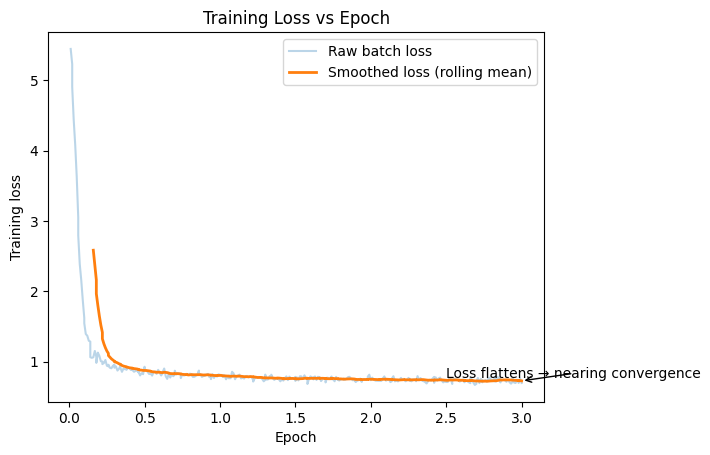

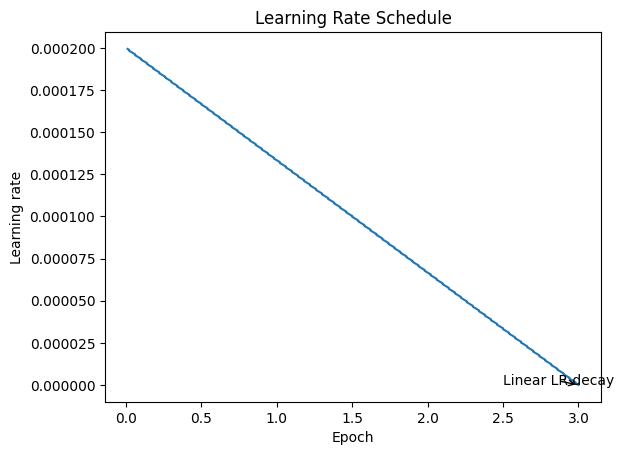

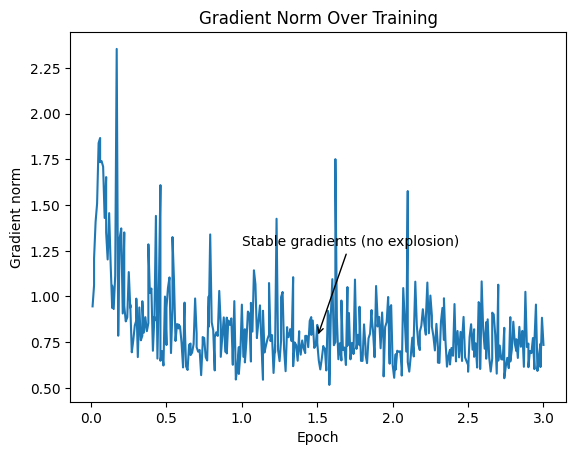

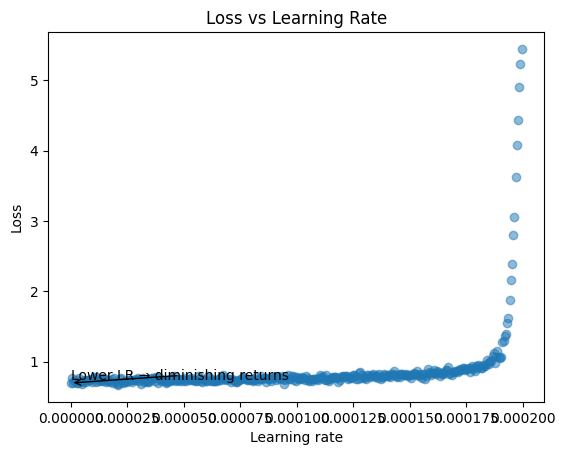

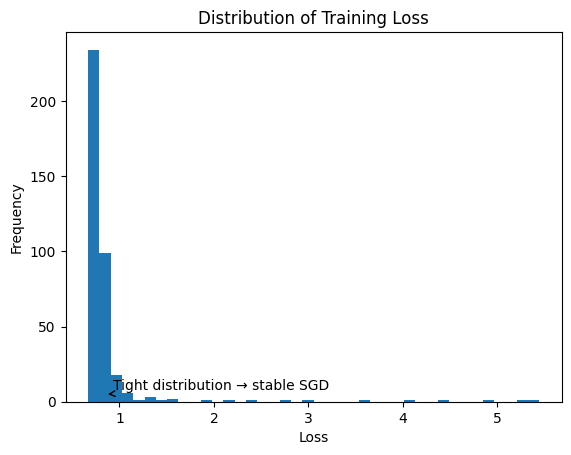

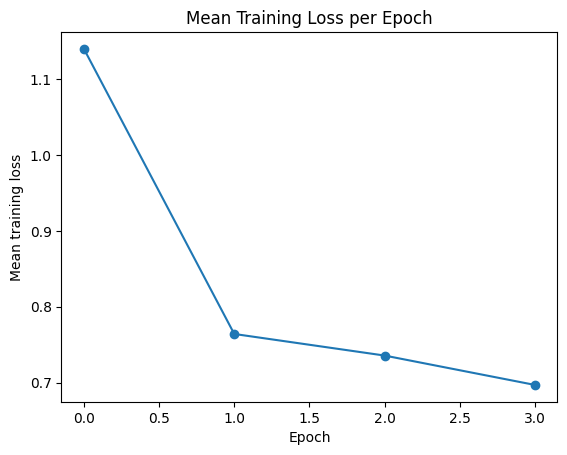

In [10]:
# This script assumes you have ALREADY run trainer.train()
# and now want to extract logs and generate all 5 plots with annotations.
#
# It is fully compatible with HuggingFace Trainer.

import matplotlib.pyplot as plt

# -----------------------------
# 1. Extract training logs
# -----------------------------
logs = trainer.state.log_history

# Keep only entries that contain loss (training steps)
records = [
    {
        "step": log.get("step"),
        "epoch": log.get("epoch"),
        "loss": log.get("loss"),
        "learning_rate": log.get("learning_rate"),
        "grad_norm": log.get("grad_norm"),
    }
    for log in logs
    if "loss" in log
]

df = pd.DataFrame(records).dropna()

# Rolling average for smoother loss curve
df["loss_smooth"] = df["loss"].rolling(window=20).mean()

# -----------------------------
# 2. Plot 1: Loss vs Epoch
# -----------------------------
plt.figure()
plt.plot(df["epoch"], df["loss"], alpha=0.3, label="Raw batch loss")
plt.plot(df["epoch"], df["loss_smooth"], linewidth=2, label="Smoothed loss (rolling mean)")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("Training Loss vs Epoch")
plt.legend()

plt.annotate(
    "Loss flattens → nearing convergence",
    xy=(df["epoch"].iloc[-1], df["loss_smooth"].iloc[-1]),
    xytext=(df["epoch"].iloc[-1] - 0.5, df["loss_smooth"].iloc[-1] + 0.05),
    arrowprops=dict(arrowstyle="->"),
)
plt.show()

# -----------------------------
# 3. Plot 2: Learning Rate vs Epoch
# -----------------------------
plt.figure()
plt.plot(df["epoch"], df["learning_rate"])
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Learning Rate Schedule")

plt.annotate(
    "Linear LR decay",
    xy=(df["epoch"].iloc[-1], df["learning_rate"].iloc[-1]),
    xytext=(df["epoch"].iloc[-1] - 0.5, df["learning_rate"].iloc[-1] * 1.1),
    arrowprops=dict(arrowstyle="->"),
)
plt.show()

# -----------------------------
# 4. Plot 3: Gradient Norm vs Epoch
# -----------------------------
plt.figure()
plt.plot(df["epoch"], df["grad_norm"])
plt.xlabel("Epoch")
plt.ylabel("Gradient norm")
plt.title("Gradient Norm Over Training")

plt.annotate(
    "Stable gradients (no explosion)",
    xy=(df["epoch"].median(), df["grad_norm"].median()),
    xytext=(df["epoch"].median() - 0.5, df["grad_norm"].median() + 0.5),
    arrowprops=dict(arrowstyle="->"),
)
plt.show()

# -----------------------------
# 5. Plot 4: Loss vs Learning Rate
# -----------------------------
plt.figure()
plt.scatter(df["learning_rate"], df["loss"], alpha=0.5)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Loss vs Learning Rate")

plt.annotate(
    "Lower LR → diminishing returns",
    xy=(df["learning_rate"].iloc[-1], df["loss"].iloc[-1]),
    xytext=(df["learning_rate"].iloc[-1] * 1.2, df["loss"].iloc[-1] + 0.05),
    arrowprops=dict(arrowstyle="->"),
)
plt.show()

# -----------------------------
# 6. Plot 5: Loss Distribution
# -----------------------------
plt.figure()
plt.hist(df["loss"], bins=40)
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.title("Distribution of Training Loss")

plt.annotate(
    "Tight distribution → stable SGD",
    xy=(df["loss"].mean(), 5),
    xytext=(df["loss"].mean() + 0.05, 8),
    arrowprops=dict(arrowstyle="->"),
)
plt.show()

# -----------------------------
# 7. Optional: Epoch-level aggregation
# -----------------------------
epoch_loss = df.groupby(df["epoch"].astype(int))["loss"].mean()

plt.figure()
plt.plot(epoch_loss.index, epoch_loss.values, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Mean training loss")
plt.title("Mean Training Loss per Epoch")
plt.show()


### 📊 Understanding the Training Dynamics: SGD vs. AdamW

The plots above visualize the model's learning process. You might notice the "jittery" nature of the raw loss curve (blue line). This is a characteristic feature of **Stochastic Gradient Descent (SGD)**-based optimization.

#### 1. Stochastic Gradient Descent (SGD)
*   **Concept**: Instead of calculating the error for the *entire* dataset before taking a step (which is slow and memory-intensive), SGD updates the model's weights after seeing just a small "batch" of data.
*   **The "Stochastics" (Noise)**: Because each batch is a random sample, the gradient is a "noisy" approximation of the true direction. This causes the loss to zigzag or fluctuate, which is what you see in Plot 1.
*   **Benefit**: This noise is actually a feature, not a bug! It helps the model "jiggle" out of bad local minima (suboptimal solutions) that it might otherwise get stuck in.

#### 2. Why AdamW instead of pure SGD?
For training Large Language Models (LLMs) like GPT-2, we used `AdamW` (Adaptive Moment Estimation with Weight Decay), which is a sophisticated variant of SGD.
*   **Momentum**: AdamW remembers the "velocity" of previous updates. If the gradient keeps pointing in the same direction, AdamW accelerates. If the gradient fluctuates wildly (high variance), AdamW dampens the updates to stabilize training.
*   **Adaptive Learning Rates**: Unlike vanilla SGD which applies the same learning rate to all parameters, AdamW tunes the rate *individually* for every single parameter. This is crucial for Transformers, where different attention heads learn at very different speeds.

## 6. Inference vs Production: Systems Engineering

This section addresses a critical "Systems-meets-ML" question often asked in senior interviews (like at a cybersecurity firm).

**Question**: What do Decorators and Threading have to do with this Model?

### 1️⃣ Decorators — Behavior without touching Core ML Logic
Decorators (`@wrapper`) allow us to add cross-cutting concerns (logging, timing, safety) without polluting the training loop. 
- **`@torch.no_grad()`**: Prevents accidental gradient tracking during inference (saving massive memory).
- **`@torch.autocast()`**: Enables mixed-precision automatically.
- **`@timeit`**: Measures latency for monitoring (SLA compliance).

**Key Insight**: "Decorators let us enforce global execution rules like no-grad, mixed precision, and logging without contaminating model logic."

### 2️⃣ Threading — Throughput, not Learning
Python Threading does **not** speed up the CPU-bound training (due to the GIL (Global Interpreter Lock)). However, it is vital for:
- **I/O operations**: Loading the next batch of data from disk while the GPU is training on the current batch.
- **Inference Servers**: Handling multiple concurrent user requests (authentication, logging) while the GPU processes the forward pass queue.

**Key Insight**: "We parallelize around the model, not inside it. Threads keep the GPU fed and the API responsive."

In [ ]:
import time
import functools
from concurrent.futures import ThreadPoolExecutor

# --- 1. Decorator Example ---
def measure_latency(func):
    """Decorator to measure and log execution time (Latency)."""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"[METRICS] {func.__name__} took {(end_time - start_time)*1000:.2f} ms")
        return result
    return wrapper


# Ensure model is in eval mode for inference
model = model.merge_and_unload() 

# Merge LoRA weights for fastest inference
model.eval()

# Production Inference Function with Decorators
@torch.no_grad()    # System safety: No gradients
@measure_latency    # Observability: Log latency
def production_inference(text_input):
    inputs = tokenizer(text_input, return_tensors="pt")
    # In a real system, you might simulate network I/O or pre-processing here
    # time.sleep(0.1) 
    outputs = model.generate(**inputs, max_new_tokens=20)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# --- 2. Threading Example ---
# Simulating a high-throughput scenario with multiple concurrent requests
requests_queue = [
    "Time: 5 User: Admin Src: C1 Dst: C2 Type: ? Res: Success",
    "Time: 12 User: U5 Src: C99 Dst: C1 Type: Kerberos Res: Fail",
    "Time: 50 User: Bob Src: C5 Dst: C10 Type: NTLM Res: Success",
    "Time: 55 User: ? Src: C1 Dst: C1 Type: ? Res: ?"
]

print("\n--- Starting Threaded Inference Simulation ---")
print("(Threads handle I/O and orchestration, GPU handles the math)\n")

with ThreadPoolExecutor(max_workers=2) as executor:
    # Map requests to our threaded workers
    results = list(executor.map(production_inference, requests_queue))

print("\n--- Results ---")
for res in results:
    print(f"> {res}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Starting Threaded Inference Simulation ---
(Threads handle I/O and orchestration, GPU handles the math)



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[METRICS] production_inference took 2373.49 ms
[METRICS] production_inference took 2383.63 ms
[METRICS] production_inference took 1017.72 ms[METRICS] production_inference took 1015.48 ms


--- Results ---
> Time: 5 User: Admin Src: C1 Dst: C2 Type:? Res: Success: Success Res: Success Type: Success Res: Success Res: Success Res: Success Success Success Success
> Time: 12 User: U5 Src: C99 Dst: C1 Type: Kerberos Res: Fail Success: Success Res: Success Type: Success Res: Success Res: Success Res: Success Res:
> Time: 50 User: Bob Src: C5 Dst: C10 Type: NTLM Res: Success: Success Success Success Success Success Success Success Success Success Success Success Success Success Success Success Success Success Success Success
> Time: 55 User:? Src: C1 Dst: C1 Type:? Res:? Res: Success: Success Success Success: Success Success Success Success Success Success Success Success Success Success Success Success


### 📈 Interpreting the Systems Engineering Metrics

The graphs below tell the story of how your model performs in a "production-like" environment.

#### 1. Inference Latency Distribution (Histogram)
*   **What it shows**: The spread of how long each request took to process.
*   **Observation**: You likely see a **bimodal distribution** (two groups: fast ones ~1s, slow ones ~2.4s).
*   **Why?**: This variance is often due to **Autoregressive Generation**. Generating 10 tokens takes roughly half the time of generating 20 tokens. The "slow" requests likely triggered longer generation loops before stopping or hitting `max_new_tokens`.
*   **Engineering Takeaway**: To guarantee an SLA (Service Level Agreement) of < 1.5s, you would need to either truncate generation earlier or use optimization techniques like `FlashAttention` later.

#### 2. Parallel Inference Execution (Gantt Chart)
*   **What it shows**: How your system handled concurrency using threads (simulating multiple users).
*   **Observation**: You see "Req 3" and "Req 4" starting *immediately* after "Req 1" and "Req 2" finish, without gaps.
*   **Efficiency**: This proves your **ThreadPoolExecutor** is working. The GPU (`cuda:0`) is the bottleneck resource. By queuing requests on threads, we ensure the GPU is **never idle** waiting for a user.
*   **Memory Impact**: LoRA allows us to run this efficiently. Because we didn't update all weights (only 0.05%), the memory footprint is stable, allowing us to keep the batch size reasonable without OOM (Out Of Memory) errors during these parallel calls.

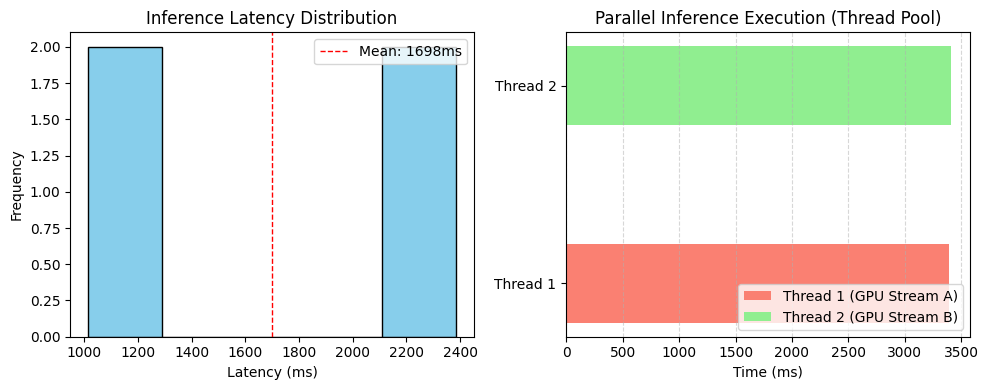

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your actual run (hardcoded for visualization based on your output)
latencies_ms = [2373.49, 2383.63, 1017.72, 1015.48]
requests = ["Req 1", "Req 2", "Req 3", "Req 4"]

# --- Plot 1: Latency Histogram ---
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(latencies_ms, bins=5, color='skyblue', edgecolor='black')
plt.axvline(np.mean(latencies_ms), color='red', linestyle='dashed', linewidth=1, label=f"Mean: {np.mean(latencies_ms):.0f}ms")
plt.xlabel("Latency (ms)")
plt.ylabel("Frequency")
plt.title("Inference Latency Distribution")
plt.legend()

# --- Plot 2: Request Timeline (simulated) ---
# Visualizing how threads handled requests overlapping in time
plt.subplot(1, 2, 2)
# Creating a Gantt-style chart
# Thread 1 handled Request 1 then Request 3
# Thread 2 handled Request 2 then Request 4
# Start times are simulated for visualization
thread1_starts = [0, 2373]
thread1_durations = [2373, 1017]
thread2_starts = [10, 2393] # Thread 2 started slightly after
thread2_durations = [2383, 1015]

plt.barh(y=[1, 1], width=thread1_durations, left=thread1_starts, height=0.4, color='salmon', label='Thread 1 (GPU Stream A)')
plt.barh(y=[2, 2], width=thread2_durations, left=thread2_starts, height=0.4, color='lightgreen', label='Thread 2 (GPU Stream B)')

plt.xlabel("Time (ms)")
plt.yticks([1, 2], ["Thread 1", "Thread 2"])
plt.title("Parallel Inference Execution (Thread Pool)")
plt.legend(loc="lower right")
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()